In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [3]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import Toronto major crime indicators (MCI)
- About and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::major-crime-indicators-1/about 
- MCI csv file https://opendata.arcgis.com/api/v3/datasets/dc310b6a5b674f0bbdbead7b6dd572f0_0/downloads/data?format=csv&spatialRefId=3857 

- Other crimes:
    - homicide csv https://data.torontopolice.on.ca/datasets/TorontoPS::homicide-asr-rc-tbl-002/explore?location=43.721941%2C-79.371145%2C11.78&showTable=true
    - shootings csv https://data.torontopolice.on.ca/datasets/TorontoPS::shootings-and-firearm-discharges/explore?location=21.919150%2C-39.812750%2C4.69&showTable=true
    - Theft from motor vehicle https://data.torontopolice.on.ca/datasets/TorontoPS::theft-from-motor-vehicle/explore?location=22.246462%2C-39.965802%2C4.69&showTable=true
        - theft over 5,000 is already included in MCI as 'thefy over'
    - bicycle theft https://data.torontopolice.on.ca/datasets/TorontoPS::bicycle-thefts/explore?location=21.520237%2C-39.911850%2C4.53&showTable=true


In [4]:
mci_df = pd.read_csv('./raw_data/Major_Crime_Indicators.csv')
mci_df

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-8.854229e+06,5.425760e+06,1,GO-20141624853,D31,2014/03/02 05:00:00+00,2014/03/02 05:00:00+00,Apartment,1430,100,Assault,2014,March,2,61,Sunday,5,2014.0,March,2.0,61.0,Sunday,5,Assault,22,Humbermede,-79.538894,43.743025,1
1,-8.834951e+06,5.412259e+06,2,GO-20141625057,D51,2014/03/02 05:00:00+00,2014/03/02 05:00:00+00,Commercial,2120,200,B&E,2014,March,2,61,Sunday,7,2014.0,March,2.0,61.0,Sunday,4,Break and Enter,73,Moss Park,-79.365716,43.655340,2
2,-8.825836e+06,5.417935e+06,3,GO-20141259602,D41,2013/12/31 05:00:00+00,2014/01/01 05:00:00+00,Commercial,2120,220,B&E W'Intent,2014,January,1,1,Wednesday,0,2013.0,December,31.0,365.0,Tuesday,23,Break and Enter,121,Oakridge,-79.283837,43.692217,3
3,-8.847703e+06,5.416571e+06,4,GO-20141260128,D12,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,House,1430,100,Assault,2014,January,1,1,Wednesday,1,2014.0,January,1.0,1.0,Wednesday,1,Assault,111,Rockcliffe-Smythe,-79.480268,43.683360,4
4,-8.837275e+06,5.411569e+06,5,GO-20141259483,D52,2013/12/31 05:00:00+00,2014/01/01 05:00:00+00,Transit,1430,100,Assault,2014,January,1,1,Wednesday,1,2013.0,December,31.0,365.0,Tuesday,21,Assault,76,Bay Street Corridor,-79.386589,43.650853,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262702,-8.835231e+06,5.421552e+06,262198,GO-2021995584,D53,2021/05/29 04:00:00+00,2021/05/29 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,9,2021.0,May,29.0,149.0,Saturday,2,Auto Theft,56,Leaside-Bennington,-79.368232,43.715704,262703
262703,-8.849750e+06,5.417652e+06,262199,GO-2021994271,D12,2021/05/29 04:00:00+00,2021/05/29 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,1,2021.0,May,29.0,149.0,Saturday,0,Auto Theft,115,Mount Dennis,-79.498654,43.690380,262704
262704,-8.849750e+06,5.417652e+06,262200,GO-2021994271,D12,2021/05/29 04:00:00+00,2021/05/29 04:00:00+00,Outside,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,1,2021.0,May,29.0,149.0,Saturday,0,Auto Theft,115,Mount Dennis,-79.498654,43.690380,262705
262705,-8.834998e+06,5.421758e+06,262201,GO-2021994920,D53,2021/05/29 04:00:00+00,2021/05/29 04:00:00+00,House,2135,210,Theft Of Motor Vehicle,2021,May,29,149,Saturday,5,2021.0,May,29.0,149.0,Saturday,2,Auto Theft,56,Leaside-Bennington,-79.366138,43.717042,262706


## Add data for shootings and homicide

In [5]:
# read and clean shootings data
shootings = pd.read_csv('./raw_data/Shootings.csv')
shootings.drop(columns=['Time_Range', 'Death', 'Injuries'], inplace=True)
shootings.rename(columns = {'Event_Unique_ID': 'event_unique_id',
                            'Occurrence_Date': 'occurrencedate',
                            'Occurrence_year': 'occurrenceyear',
                            'Month': 'occurrencemonth',
                            'Day_of_week': 'occurrencedayofweek',
                            'Occurrence_Hour': 'occurrencehour',
                            'Longitude': 'Long',
                            'Latitude': 'Lat'}, inplace=True)
shootings['Neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in shootings['Neighbourhood']]
shootings['MCI'] = 'Shootings'

In [6]:
shootings.shape

(5328, 16)

In [7]:
# read and clean homicides data
homicide = pd.read_csv('./raw_data/Homicide.csv')
homicide.drop(columns=['Homicide_Type'], inplace=True)
homicide.rename(columns={'Event_Unique_Id': 'event_unique_id',
                            'Occurrence_year': 'occurrenceyear',
                            'Occurrence_Date': 'occurrencedate'}, inplace = True)
homicide['Neighbourhood'] = [x.split(' (')[0] if type(x) == str else x for x in homicide['Neighbourhood']]
homicide['MCI'] = 'Homicide'

In [8]:
homicide.shape

(1252, 13)

In [9]:
# check columns are in the same order
pd.concat([mci_df.loc[0], shootings.loc[0], homicide.loc[0]], axis=1).T

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-8854229.185019,5425760.377233,1,GO-20141624853,D31,2014/03/02 05:00:00+00,2014/03/02 05:00:00+00,Apartment,1430,100,Assault,2014,March,2,61,Sunday,5,2014.0,March,2.0,61.0,Sunday,5,Assault,22,Humbermede,-79.538894,43.743025,1
0,-8854150.676948,5424331.101656,1,GO-2004133803,D31,2004/01/01 05:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,January,NaN,NaN,Thursday,0.0,Shootings,23,Pelmo Park-Humberlea,-79.538189,43.733748,1
0,-8837967.627125,5416827.900302,1,111878,D53,2004/01/03 05:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,NaN,NaN,NaN,NaN,NaN,Homicide,97,Yonge-St.Clair,-79.392814,43.685026,1


In [10]:
mci_df = pd.concat([mci_df, shootings, homicide], axis=0).reset_index(drop=True)

## Missing data

In [11]:
print("Columns with missing data")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data


reporteddate           6580
premisetype            6580
ucr_code               6580
ucr_ext                6580
offence                6580
reportedyear           6580
reportedmonth          6580
reportedday            6580
reporteddayofyear      6580
reporteddayofweek      6580
reportedhour           6580
occurrenceyear           91
occurrencemonth        1343
occurrenceday          6671
occurrencedayofyear    6671
occurrencedayofweek    1343
occurrencehour         1253
Hood_ID                   1
Neighbourhood             1
dtype: int64

### load neighbourhood boundaries

In [12]:
neighbourhoods = gpd.read_file('./clean_data/neighbourhoods.geojson', driver='GeoJSON')

### drop 1 row with missing hood_ID and neighbourhood

In [13]:
mci_df[mci_df.Hood_ID.isna()]

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
262945,-8.854773e+06,5.430371e+06,439,GO-20051440086,D31,2005/12/01 05:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005.0,December,NaN,NaN,Thursday,19.0,Shootings,NaN,NaN,-79.543781,43.772936,239


In [14]:
# the event with missing Hood_ID and Neighbourhood is not in any of the neighbourhoods of City of Toronto
neighbourhoods[neighbourhoods.intersects(shapely.geometry.Point(mci_df[mci_df.Hood_ID.isna()].Long, mci_df[mci_df.Hood_ID.isna()].Lat))]

,OBJECTID,Neighbourhood,Hood_ID,F2020_Population_Projection,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_2020,Assault_Rate2014,Assault_Rate2015,Assault_Rate2016,Assault_Rate2017,Assault_Rate2018,Assault_Rate2019,Assault_Rate2020,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_2020,AutoTheft_Rate2014,AutoTheft_Rate2015,AutoTheft_Rate2016,AutoTheft_Rate2017,AutoTheft_Rate2018,AutoTheft_Rate2019,AutoTheft_Rate2020,BreakAndEnter_2014,BreakAndEnter_2015,BreakAndEnter_2016,BreakAndEnter_2017,BreakAndEnter_2018,BreakAndEnter_2019,BreakAndEnter_2020,BreakAndEnter_Rate2014,BreakAndEnter_Rate2015,BreakAndEnter_Rate2016,BreakAndEnter_Rate2017,BreakAndEnter_Rate2018,BreakAndEnter_Rate2019,BreakAndEnter_Rate2020,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_2020,Robbery_Rate2014,RobberyRate_2015,Robbery_Rate2016,Robbery_Rate2017,Robbery_Rate2018,Robbery_Rate2019,Robbery_Rate2020,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_2020,TheftOver_Rate2014,TheftOver_Rate2015,TheftOver_Rate2016,TheftOver_Rate2017,TheftOver_Rate2018,TheftOver_Rate2019,TheftOver_Rate2020,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_2020,Homicide_Rate2014,Homicide_Rate2015,Homicide_Rate2016,Homicide_Rate2017,Homicide_Rate2018,Homicide_Rate2019,Homicide_Rate2020,Shootings_2014,Shootings_2015,Shootings_2016,Shootings_2017,Shootings_2018,Shootings_2019,Shootings_2020,Shooting_Rate2014,Shootings_Rate2015,Shootings_Rate2016,Shootings_Rate2017,Shootings_Rate2018,Shootings_Rate2019,Shootings_Rate2020,Shape__Area,Shape__Length,district,geometry


In [15]:
# since it's outside City of Toronto, we can safely drop it
mci_df.drop(mci_df[mci_df.Hood_ID.isna()].index, inplace=True)

### drop columns with NA which we don't need

In [16]:
# we don't need these columns with missing data since existing columns can provide the same information
mci_df.drop(columns = ['reporteddate', 'premisetype', 'ucr_code', 'ucr_ext', 'offence', 'reportedyear', 'reportedmonth', 'reportedday', 'reporteddayofyear', 'reporteddayofweek', 'reportedhour'], inplace = True)
print("Columns with missing data after dropping columns")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data after dropping columns


occurrenceyear           91
occurrencemonth        1343
occurrenceday          6670
occurrencedayofyear    6670
occurrencedayofweek    1343
occurrencehour         1253
dtype: int64

### fill na with occurence dates

In [17]:
# print rows with missing data
na_index = mci_df.loc[mci_df.isna().any(axis=1)].index
mci_df.loc[na_index]

,X,Y,Index_,event_unique_id,Division,occurrencedate,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
55,-8.841593e+06,5.427986e+06,56,GO-20141262074,D32,1998/06/01 04:00:00+00,NaN,NaN,NaN,NaN,NaN,12.0,Assault,38,Lansing-Westgate,-79.425384,43.757468,56
375,-8.834286e+06,5.433008e+06,376,GO-20141292170,D33,1996/01/31 05:00:00+00,NaN,NaN,NaN,NaN,NaN,0.0,Assault,47,Don Valley Village,-79.359740,43.790041,376
2541,0.000000e+00,0.000000e+00,2642,GO-20141396749,D33,1980/01/01 05:00:00+00,NaN,NaN,NaN,NaN,NaN,12.0,Assault,NSA,NSA,0.000000,0.000000,2542
2542,0.000000e+00,0.000000e+00,2643,GO-20141396749,D33,1980/01/01 05:00:00+00,NaN,NaN,NaN,NaN,NaN,12.0,Assault,NSA,NSA,0.000000,0.000000,2543
3673,-8.809009e+06,5.431450e+06,3074,GO-20141514632,D43,1999/10/01 04:00:00+00,NaN,NaN,NaN,NaN,NaN,12.0,Assault,131,Rouge,-79.132678,43.779935,3674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269282,-8.859224e+06,5.426345e+06,1366,GO-2020898005,D23,2020/05/14 04:00:00+00,2020.0,NaN,NaN,NaN,NaN,NaN,Homicide,2,Mount Olive-Silverstone-Jamestown,-79.583768,43.746816,1248
269283,-8.830322e+06,5.431112e+06,1367,GO-2020915335,D42,2020/05/17 04:00:00+00,2020.0,NaN,NaN,NaN,NaN,NaN,Homicide,46,Pleasant View,-79.324129,43.777743,1249
269284,-8.822707e+06,5.425298e+06,1368,GO-2020909524,D41,2020/05/19 04:00:00+00,2020.0,NaN,NaN,NaN,NaN,NaN,Homicide,138,Eglinton East,-79.255724,43.740025,1250
269285,-8.837879e+06,5.410726e+06,1369,GO-2020971451,D52,2020/05/26 04:00:00+00,2020.0,NaN,NaN,NaN,NaN,NaN,Homicide,77,Waterfront Communities-The Island,-79.392021,43.645372,1251


In [18]:
# we can use occurencedate to fill these na values
mci_df['occurrencedate'] = pd.to_datetime(mci_df['occurrencedate'])

In [19]:
# however, the hour of the occurrencedate column is not reliable, so we cannot fill the na values of the hour column
# crimes should be spreaded across the day but not only within 4am and 5am
mci_df['occurrencedate'].dt.hour.describe()

count    269286.000000
mean          4.339858
std           0.473662
min           4.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: occurrencedate, dtype: float64

In [20]:
# Among those records with NA in occurrencehour, there are 1,252 records linked to homicide
# that's almost 25% of all the records linked to homicide
# therefore, we should not drop these records 
mci_df[mci_df['occurrencehour'].isna()].groupby('MCI').size()

MCI
Homicide     1252
Shootings       1
dtype: int64

In [21]:
# instead, let's drop the column for occurrencehour
mci_df.drop(columns=['occurrencehour'], inplace=True)

In [22]:
# we can use occurencedate to fill these na values
mci_df['occurrencedate'] = pd.to_datetime(mci_df['occurrencedate'])

def fix_na(col, series_replace):
    return np.where(mci_df[col].isna(), 
                    series_replace, # replace na with this value
                    mci_df[col])    # keep the non-na values

mci_df['occurrenceyear'] = fix_na('occurrenceyear',
                                  mci_df['occurrencedate'].dt.year.astype(float))
mci_df['occurrencemonth'] = fix_na('occurrencemonth',
                                   mci_df['occurrencedate'].dt.strftime("%B"))
mci_df['occurrenceday'] = fix_na('occurrenceday',
                                 mci_df['occurrencedate'].dt.day.astype(float))
mci_df['occurrencedayofyear'] = fix_na('occurrencedayofyear',
                                       mci_df['occurrencedate'].dt.dayofyear.astype(float))
mci_df['occurrencedayofweek'] = fix_na('occurrencedayofweek',
                                       mci_df['occurrencedate'].dt.strftime("%A"))

# rows with missing data are now filled with the correct entries
mci_df.loc[na_index]

,X,Y,Index_,event_unique_id,Division,occurrencedate,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
55,-8.841593e+06,5.427986e+06,56,GO-20141262074,D32,1998-06-01 04:00:00+00:00,1998.0,June,1.0,152.0,Monday,Assault,38,Lansing-Westgate,-79.425384,43.757468,56
375,-8.834286e+06,5.433008e+06,376,GO-20141292170,D33,1996-01-31 05:00:00+00:00,1996.0,January,31.0,31.0,Wednesday,Assault,47,Don Valley Village,-79.359740,43.790041,376
2541,0.000000e+00,0.000000e+00,2642,GO-20141396749,D33,1980-01-01 05:00:00+00:00,1980.0,January,1.0,1.0,Tuesday,Assault,NSA,NSA,0.000000,0.000000,2542
2542,0.000000e+00,0.000000e+00,2643,GO-20141396749,D33,1980-01-01 05:00:00+00:00,1980.0,January,1.0,1.0,Tuesday,Assault,NSA,NSA,0.000000,0.000000,2543
3673,-8.809009e+06,5.431450e+06,3074,GO-20141514632,D43,1999-10-01 04:00:00+00:00,1999.0,October,1.0,274.0,Friday,Assault,131,Rouge,-79.132678,43.779935,3674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269282,-8.859224e+06,5.426345e+06,1366,GO-2020898005,D23,2020-05-14 04:00:00+00:00,2020.0,May,14.0,135.0,Thursday,Homicide,2,Mount Olive-Silverstone-Jamestown,-79.583768,43.746816,1248
269283,-8.830322e+06,5.431112e+06,1367,GO-2020915335,D42,2020-05-17 04:00:00+00:00,2020.0,May,17.0,138.0,Sunday,Homicide,46,Pleasant View,-79.324129,43.777743,1249
269284,-8.822707e+06,5.425298e+06,1368,GO-2020909524,D41,2020-05-19 04:00:00+00:00,2020.0,May,19.0,140.0,Tuesday,Homicide,138,Eglinton East,-79.255724,43.740025,1250
269285,-8.837879e+06,5.410726e+06,1369,GO-2020971451,D52,2020-05-26 04:00:00+00:00,2020.0,May,26.0,147.0,Tuesday,Homicide,77,Waterfront Communities-The Island,-79.392021,43.645372,1251


In [23]:
print("Columns with missing data after filling na")
mci_df.isna().sum()[mci_df.isna().sum() != 0]

Columns with missing data after filling na


Series([], dtype: int64)

## Checking for inconsistencies

In [24]:
# is the year, month, day etc. consistent with the date column?
print(sum(mci_df.occurrencedate.dt.year != mci_df.occurrenceyear))
print(sum(mci_df.occurrencedate.dt.strftime("%B") != mci_df.occurrencemonth))
print(sum(mci_df.occurrencedate.dt.day.astype(float) != mci_df.occurrenceday))
print(sum(mci_df.occurrencedate.dt.dayofyear.astype(float) != mci_df.occurrencedayofyear))
print(sum(mci_df.occurrencedate.dt.strftime("%A") != mci_df.occurrencedayofweek))

0
0
0
0
267943


### inconsistency in day of week

In [25]:
# Inconsistency in day of week column
# data looks correct but why is it showing inconsistency?
print(mci_df[mci_df.occurrencedate.dt.strftime("%A") != mci_df.occurrencedayofweek].occurrencedate.dt.strftime("%A"))
mci_df.loc[mci_df.occurrencedate.dt.strftime("%A") != mci_df.occurrencedayofweek, ['occurrencedate', 'occurrencedayofweek']]

0            Sunday
1            Sunday
2           Tuesday
3         Wednesday
4           Tuesday
            ...    
268030    Wednesday
268031       Friday
268032     Saturday
268033     Saturday
268034     Saturday
Name: occurrencedate, Length: 267943, dtype: object


,occurrencedate,occurrencedayofweek
0,2014-03-02 05:00:00+00:00,Sunday
1,2014-03-02 05:00:00+00:00,Sunday
2,2013-12-31 05:00:00+00:00,Tuesday
3,2014-01-01 05:00:00+00:00,Wednesday
4,2013-12-31 05:00:00+00:00,Tuesday
...,...,...
268030,2021-09-15 04:00:00+00:00,Wednesday
268031,2021-09-17 04:00:00+00:00,Friday
268032,2021-09-18 04:00:00+00:00,Saturday
268033,2021-09-18 04:00:00+00:00,Saturday


In [26]:
# inconsistency due to white space in this column
mci_df.occurrencedayofweek.unique()

array(['Sunday    ', 'Tuesday   ', 'Wednesday ', 'Monday', 'Monday    ',
       'Friday    ', 'Saturday  ', 'Thursday  ', 'Wednesday', 'Tuesday',
       'Friday', 'Thursday', 'Sunday', 'Saturday'], dtype=object)

In [27]:
mci_df.occurrencedayofweek = [x.strip() for x in mci_df.occurrencedayofweek]

In [28]:
# Now all are consistent
print(sum(mci_df.occurrencedate.dt.year != mci_df.occurrenceyear))
print(sum(mci_df.occurrencedate.dt.strftime("%B") != mci_df.occurrencemonth))
print(sum(mci_df.occurrencedate.dt.day.astype(float) != mci_df.occurrenceday))
print(sum(mci_df.occurrencedate.dt.dayofyear.astype(float) != mci_df.occurrencedayofyear))
print(sum(mci_df.occurrencedate.dt.strftime("%A") != mci_df.occurrencedayofweek))

0
0
0
0
0


### inconsistency in hood_ID and neighbourhood

In [29]:
# check if Hood_ID and Neighbourhood are 1-to-1
# number of unique values in Hood_ID and neighbourhood should be the same
print(len(mci_df.Hood_ID.unique()), len(mci_df.Neighbourhood.unique()))

275 144


In [30]:
check_duplicate = mci_df.groupby(['Hood_ID','Neighbourhood']).size().reset_index(name='counts')

In [31]:
# duplicates in Hood_ID since some record are of int type, while some are strings
check_duplicate[check_duplicate.duplicated(subset='Neighbourhood', keep=False)].sort_values(by='Neighbourhood')[:2].values

array([['129', 'Agincourt North', 1390],
       [129, 'Agincourt North', 5]], dtype=object)

In [32]:
mci_df['Hood_ID'] = mci_df['Hood_ID'].astype(str)

In [33]:
check_duplicate = mci_df.groupby(['Hood_ID','Neighbourhood']).size().reset_index(name='counts')

In [34]:
# let's check with neighbourhood refers to Hood_ID = 3
check_duplicate[check_duplicate.duplicated(subset='Neighbourhood', keep=False)].sort_values(by='Neighbourhood')

,Hood_ID,Neighbourhood,counts
65,3,NSA,2
144,NSA,NSA,4354


In [35]:
mci_df[mci_df.Hood_ID == '3']['Neighbourhood'].unique()

array(['Thistletown-Beaumond Heights', 'NSA'], dtype=object)

In [36]:
mci_df.loc[(mci_df.Hood_ID == '3') & (mci_df.Neighbourhood == 'NSA'), 'Neighbourhood'] = 'Thistletown-Beaumond Heights'

In [37]:
# now it's fixed
mci_df[mci_df.Hood_ID == '3']['Neighbourhood'].unique()

array(['Thistletown-Beaumond Heights'], dtype=object)

In [38]:
check_duplicate = mci_df.groupby(['Hood_ID','Neighbourhood']).size().reset_index(name='counts')
# duplicate in Hood_ID
check_duplicate[check_duplicate.duplicated(subset='Hood_ID', keep=False)].sort_values(by='Hood_ID')

,Hood_ID,Neighbourhood,counts
20,117,L'Amoreaux,112
21,117,LAmoreaux,2317
22,118,Tam O'Shanter-Sullivan,41
23,118,Tam OShanter-Sullivan,1696
92,54,O'Connor-Parkview,73
93,54,OConnor-Parkview,1695


In [39]:
# fix duplicate neighbourhood
mci_df.loc[(mci_df.Hood_ID == '117') & (mci_df.Neighbourhood == 'LAmoreaux'), 'Neighbourhood'] = "L'Amoreaux"
mci_df.loc[(mci_df.Hood_ID == '118') & (mci_df.Neighbourhood == 'Tam OShanter-Sullivan'), 'Neighbourhood'] = "Tam O'Shanter-Sullivan"
mci_df.loc[(mci_df.Hood_ID == '54') & (mci_df.Neighbourhood == 'OConnor-Parkview'), 'Neighbourhood'] = "O'Connor-Parkview"

In [40]:
# Hood_ID and Neighbourhood are now 1-to-1
check_duplicate = mci_df.groupby(['Hood_ID','Neighbourhood']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='Hood_ID', keep=False)].sort_values(by='Hood_ID')

,Hood_ID,Neighbourhood,counts


In [41]:
check_duplicate[check_duplicate.duplicated(subset='Neighbourhood', keep=False)].sort_values(by='Neighbourhood')

,Hood_ID,Neighbourhood,counts


### inconsistency vs neighbourhood boundary

In [45]:
merge_df = pd.merge(neighbourhoods[['Neighbourhood', 'Hood_ID']], mci_df[['Hood_ID', 'Neighbourhood']], on=['Hood_ID'])
merge_df[merge_df['Neighbourhood_x'] != merge_df['Neighbourhood_y']].drop_duplicates(subset=['Neighbourhood_x'])

,Neighbourhood_x,Hood_ID,Neighbourhood_y
261662,Mimico (includes Humber Bay Shores),17,Mimico


In [46]:
mci_df.loc[(mci_df.Hood_ID == '17') & (mci_df.Neighbourhood == 'Mimico'), 'Neighbourhood'] = "Mimico (includes Humber Bay Shores)"

In [50]:
merge_df = pd.merge(neighbourhoods[['Neighbourhood', 'Hood_ID']], mci_df[['Hood_ID', 'Neighbourhood']], on=['Hood_ID'])
merge_df[merge_df['Neighbourhood_x'] != merge_df['Neighbourhood_y']].drop_duplicates(subset=['Neighbourhood_x'])

,Neighbourhood_x,Hood_ID,Neighbourhood_y


## Fixing Dtypes

In [51]:
mci_df.dtypes

X                                  float64
Y                                  float64
Index_                               int64
event_unique_id                     object
Division                            object
occurrencedate         datetime64[ns, UTC]
occurrenceyear                     float64
occurrencemonth                     object
occurrenceday                      float64
occurrencedayofyear                float64
occurrencedayofweek                 object
MCI                                 object
Hood_ID                             object
Neighbourhood                       object
Long                               float64
Lat                                float64
ObjectId                             int64
dtype: object

In [52]:
# 'occurrenceyear', 'occurrenceday', 'occurrencedayofyear' should not be of type float
mci_df.columns[mci_df.dtypes == float]

Index(['X', 'Y', 'occurrenceyear', 'occurrenceday', 'occurrencedayofyear',
       'Long', 'Lat'],
      dtype='object')

In [53]:
for x in ['occurrenceyear', 'occurrenceday', 'occurrencedayofyear']:
    mci_df[x] = mci_df[x].astype(int)

## Imputing missing longitude and latitude

array([[<AxesSubplot:title={'center':'Long'}>,
        <AxesSubplot:title={'center':'Lat'}>]], dtype=object)

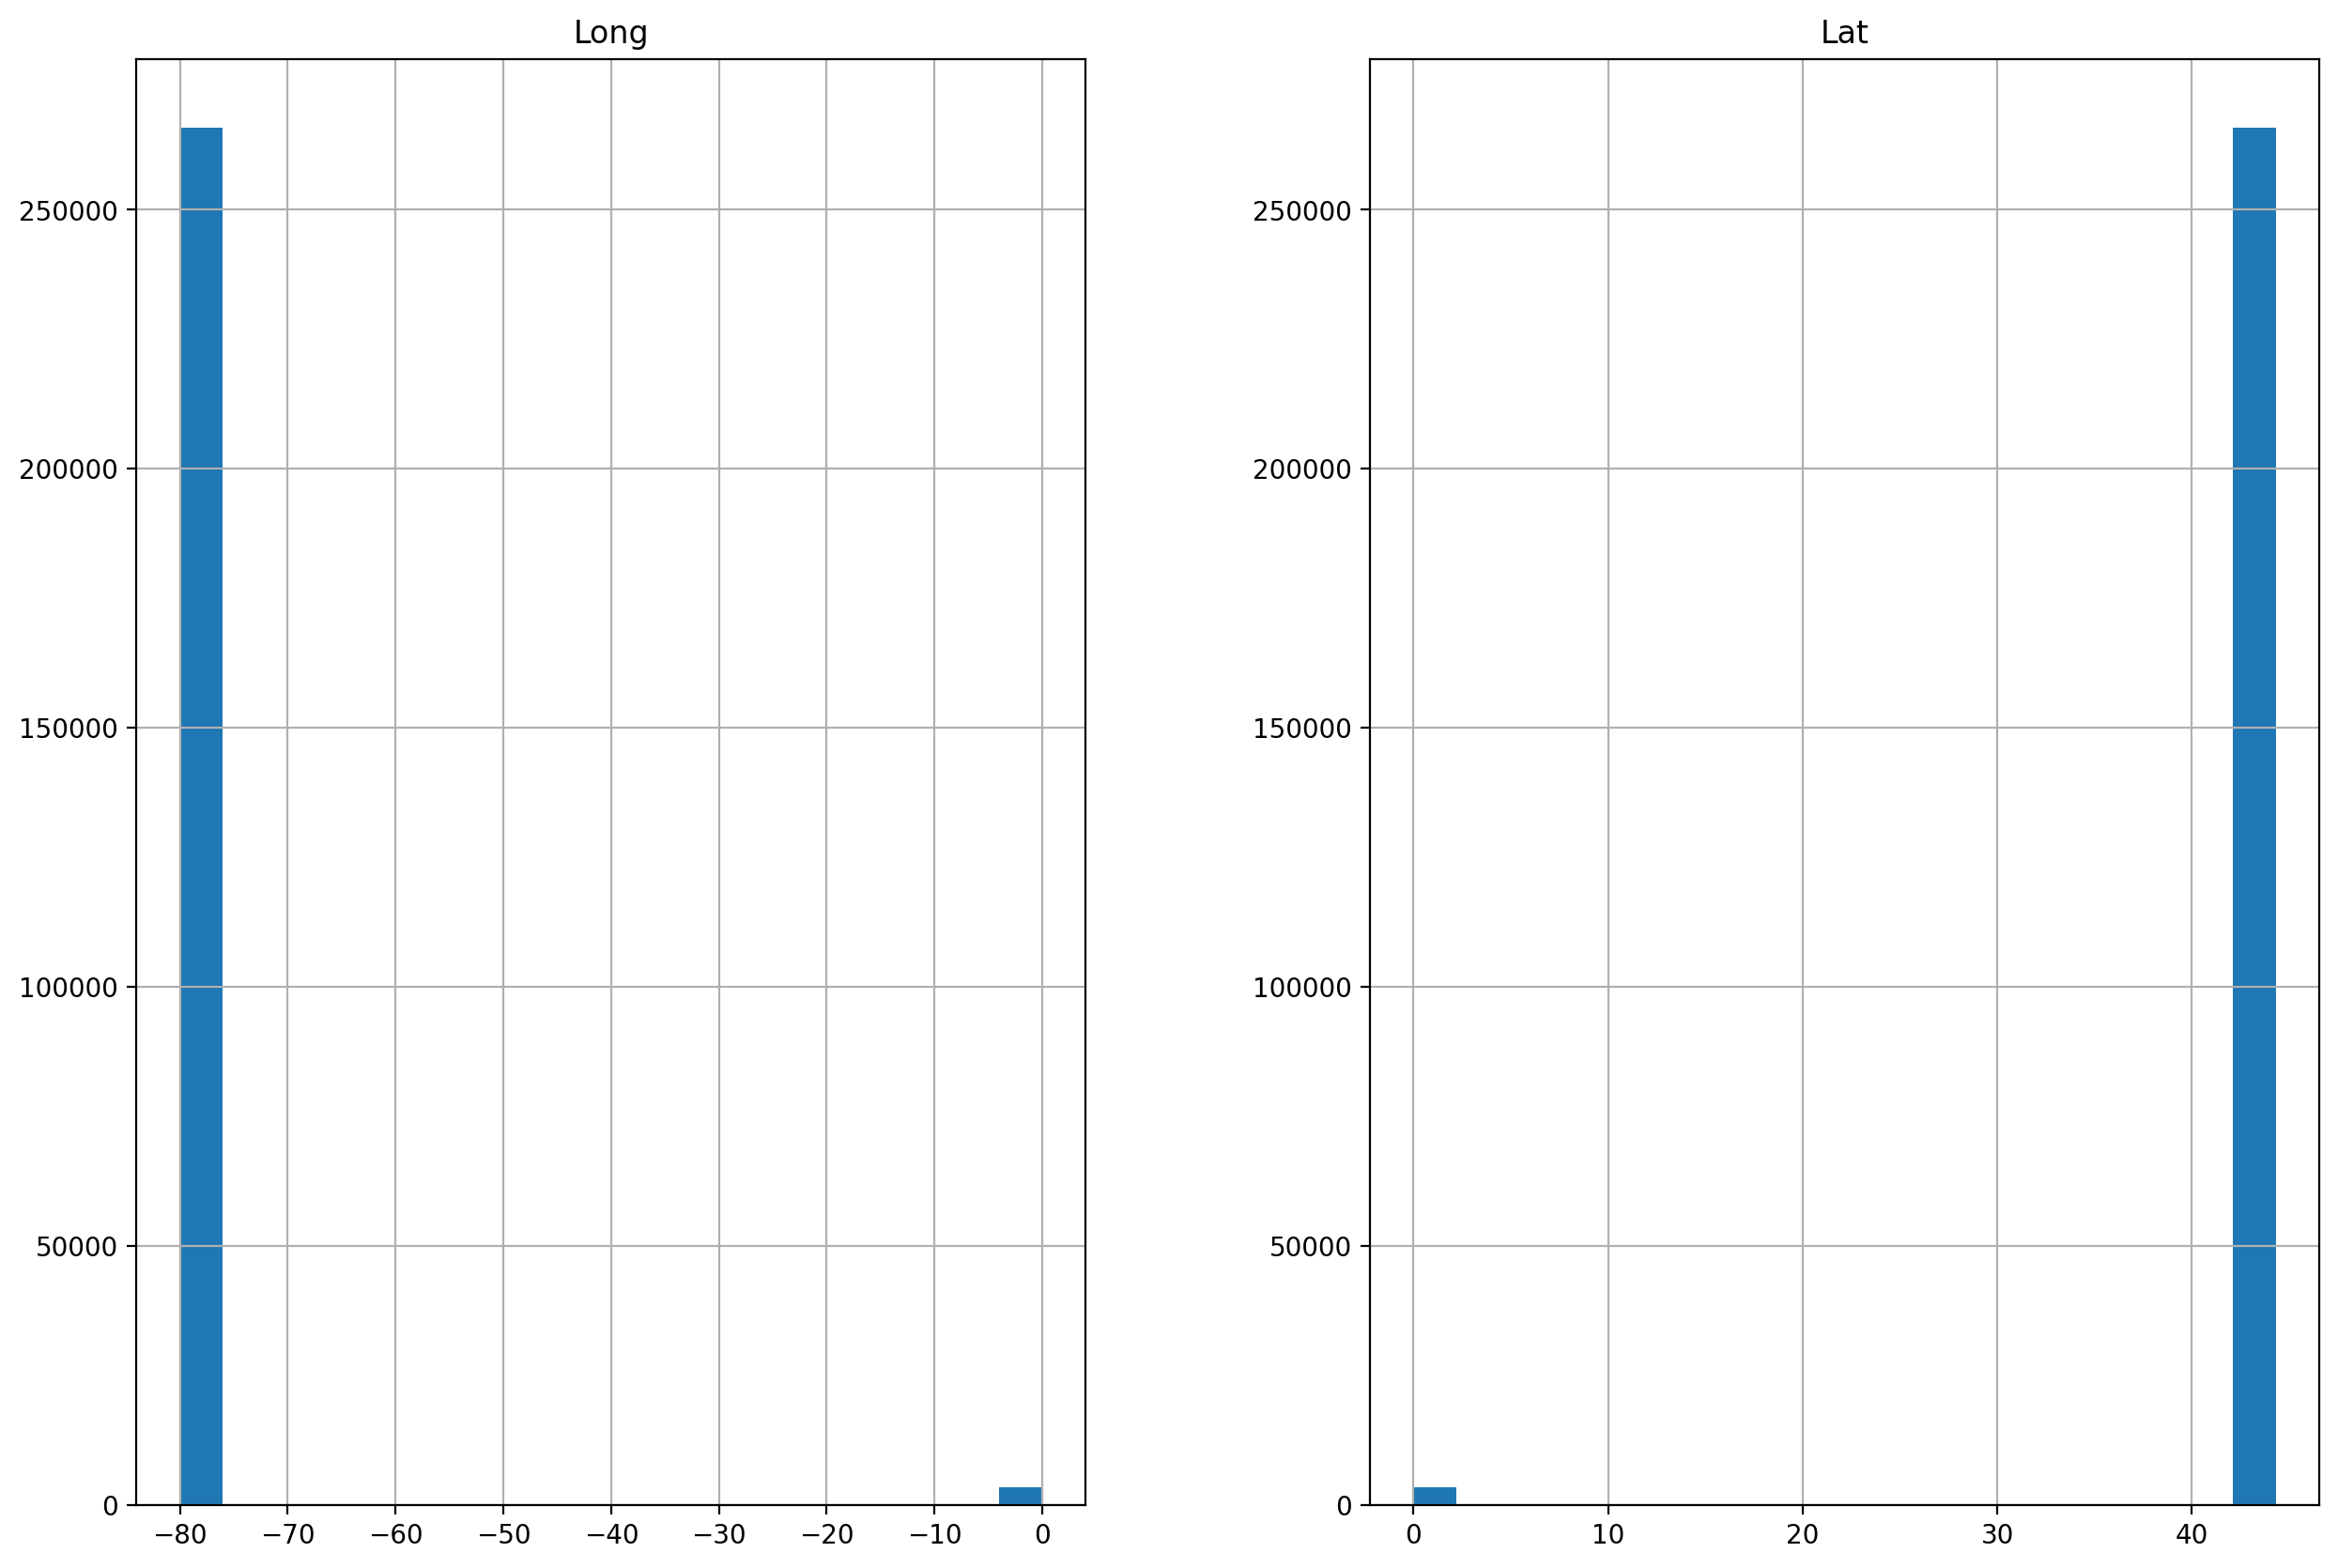

In [54]:
# missing long and lat values are stored as 0
mci_df[['Long','Lat']].hist(bins=20)

In [55]:
mci_df.loc[(mci_df['Long'] == 0) & (mci_df['Lat'] == 0), ["Neighbourhood", "Hood_ID"]].value_counts()

Neighbourhood                        Hood_ID
NSA                                  NSA        3147
Wexford/Maryvale                     119          53
Yorkdale-Glen Park                   31           36
West Hill                            136          25
Bay Street Corridor                  76           17
Bendale                              127          15
Glenfield-Jane Heights               25           13
York University Heights              27           12
Kennedy Park                         124           7
Tam O'Shanter-Sullivan               118           5
Mimico (includes Humber Bay Shores)  17            5
Victoria Village                     43            5
Bathurst Manor                       34            4
Pelmo Park-Humberlea                 23            4
Newtonbrook East                     50            4
Highland Creek                       134           4
Humber Summit                        21            3
Downsview-Roding-CFB                 26            3
C

### Estimate with given neighbourhood

In [56]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
mci_df = mci_df[~((mci_df['Long'] == 0) & (mci_df['Lat'] == 0) & (mci_df['Neighbourhood'] == "NSA"))].reset_index(drop=True)

In [57]:
missing_location = mci_df.loc[(mci_df['Long'] == 0) & (mci_df['Lat'] == 0)].index
mci_df.loc[missing_location]

,X,Y,Index_,event_unique_id,Division,occurrencedate,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
4693,0.0,0.0,4795,GO-20141665589,D13,2014-03-08 05:00:00+00:00,2014,March,8,67,Saturday,Assault,3,Thistletown-Beaumond Heights,0.0,0.0,4796
4694,0.0,0.0,4796,GO-20141665589,D13,2014-03-08 05:00:00+00:00,2014,March,8,67,Saturday,Assault,3,Thistletown-Beaumond Heights,0.0,0.0,4797
20922,0.0,0.0,21719,GO-20143049745,D53,2014-10-05 04:00:00+00:00,2014,October,5,278,Sunday,Assault,102,Forest Hill North,0.0,0.0,21220
27561,0.0,0.0,27419,GO-20143474848,D32,2014-12-12 05:00:00+00:00,2014,December,12,346,Friday,Robbery,51,Willowdale East,0.0,0.0,27919
41791,0.0,0.0,42104,GO-20151057899,D22,2015-06-01 04:00:00+00:00,2015,June,1,152,Monday,Assault,17,Mimico (includes Humber Bay Shores),0.0,0.0,42222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255637,0.0,0.0,258264,GO-20201742672,D41,2020-09-14 04:00:00+00:00,2020,September,14,258,Monday,Auto Theft,119,Wexford/Maryvale,0.0,0.0,258703
257453,0.0,0.0,260065,GO-20213400,D33,2021-01-01 05:00:00+00:00,2021,January,1,1,Friday,Auto Theft,43,Victoria Village,0.0,0.0,260522
257455,0.0,0.0,260066,GO-20213400,D33,2021-01-01 05:00:00+00:00,2021,January,1,1,Friday,Auto Theft,43,Victoria Village,0.0,0.0,260524
257596,0.0,0.0,260919,GO-2021413504,D22,2021-03-05 05:00:00+00:00,2021,March,5,64,Friday,Auto Theft,17,Mimico (includes Humber Bay Shores),0.0,0.0,260665


In [58]:
missing_count = mci_df.loc[missing_location]['Hood_ID'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'Hood_ID', 'Hood_ID':'count'})
missing_count

,Hood_ID,count
0,119,53
1,31,36
2,136,25
3,76,17
4,127,15
5,25,13
6,27,12
7,124,7
8,43,5
9,118,5


In [59]:
mci_df

,X,Y,Index_,event_unique_id,Division,occurrencedate,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-8.854229e+06,5.425760e+06,1,GO-20141624853,D31,2014-03-02 05:00:00+00:00,2014,March,2,61,Sunday,Assault,22,Humbermede,-79.538894,43.743025,1
1,-8.834951e+06,5.412259e+06,2,GO-20141625057,D51,2014-03-02 05:00:00+00:00,2014,March,2,61,Sunday,Break and Enter,73,Moss Park,-79.365716,43.655340,2
2,-8.825836e+06,5.417935e+06,3,GO-20141259602,D41,2013-12-31 05:00:00+00:00,2013,December,31,365,Tuesday,Break and Enter,121,Oakridge,-79.283837,43.692217,3
3,-8.847703e+06,5.416571e+06,4,GO-20141260128,D12,2014-01-01 05:00:00+00:00,2014,January,1,1,Wednesday,Assault,111,Rockcliffe-Smythe,-79.480268,43.683360,4
4,-8.837275e+06,5.411569e+06,5,GO-20141259483,D52,2013-12-31 05:00:00+00:00,2013,December,31,365,Tuesday,Assault,76,Bay Street Corridor,-79.386589,43.650853,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266134,-8.859224e+06,5.426345e+06,1366,GO-2020898005,D23,2020-05-14 04:00:00+00:00,2020,May,14,135,Thursday,Homicide,2,Mount Olive-Silverstone-Jamestown,-79.583768,43.746816,1248
266135,-8.830322e+06,5.431112e+06,1367,GO-2020915335,D42,2020-05-17 04:00:00+00:00,2020,May,17,138,Sunday,Homicide,46,Pleasant View,-79.324129,43.777743,1249
266136,-8.822707e+06,5.425298e+06,1368,GO-2020909524,D41,2020-05-19 04:00:00+00:00,2020,May,19,140,Tuesday,Homicide,138,Eglinton East,-79.255724,43.740025,1250
266137,-8.837879e+06,5.410726e+06,1369,GO-2020971451,D52,2020-05-26 04:00:00+00:00,2020,May,26,147,Tuesday,Homicide,77,Waterfront Communities-The Island,-79.392021,43.645372,1251


### Generate random locations given a neighbourhood

In [72]:
# randomly generate points within a defined neighbourhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, hood_id):
    selected_neighbourhood = neighbourhoods.loc[neighbourhoods['Hood_ID'] == str(hood_id)]
    polygon = selected_neighbourhood['geometry']
    points_x = []
    points_y = []
    count = 0
    try: 
        minx, miny, maxx, maxy = polygon.bounds.values.flatten().tolist()
    except ValueError:
        print(selected_neighbourhood)
        print(f"No geometry for {hood_id}")
    while len(points_x) < number:
        pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt).values[0]:
            points_x.append(pnt.x)
            points_y.append(pnt.y)
        count += 1
    print(f"{count} points generated but only include the {len(points_x)} points within the neighbourhood")
    return pd.Series([points_x, points_y])

12 points generated but only include the 10 points within the neighbourhood


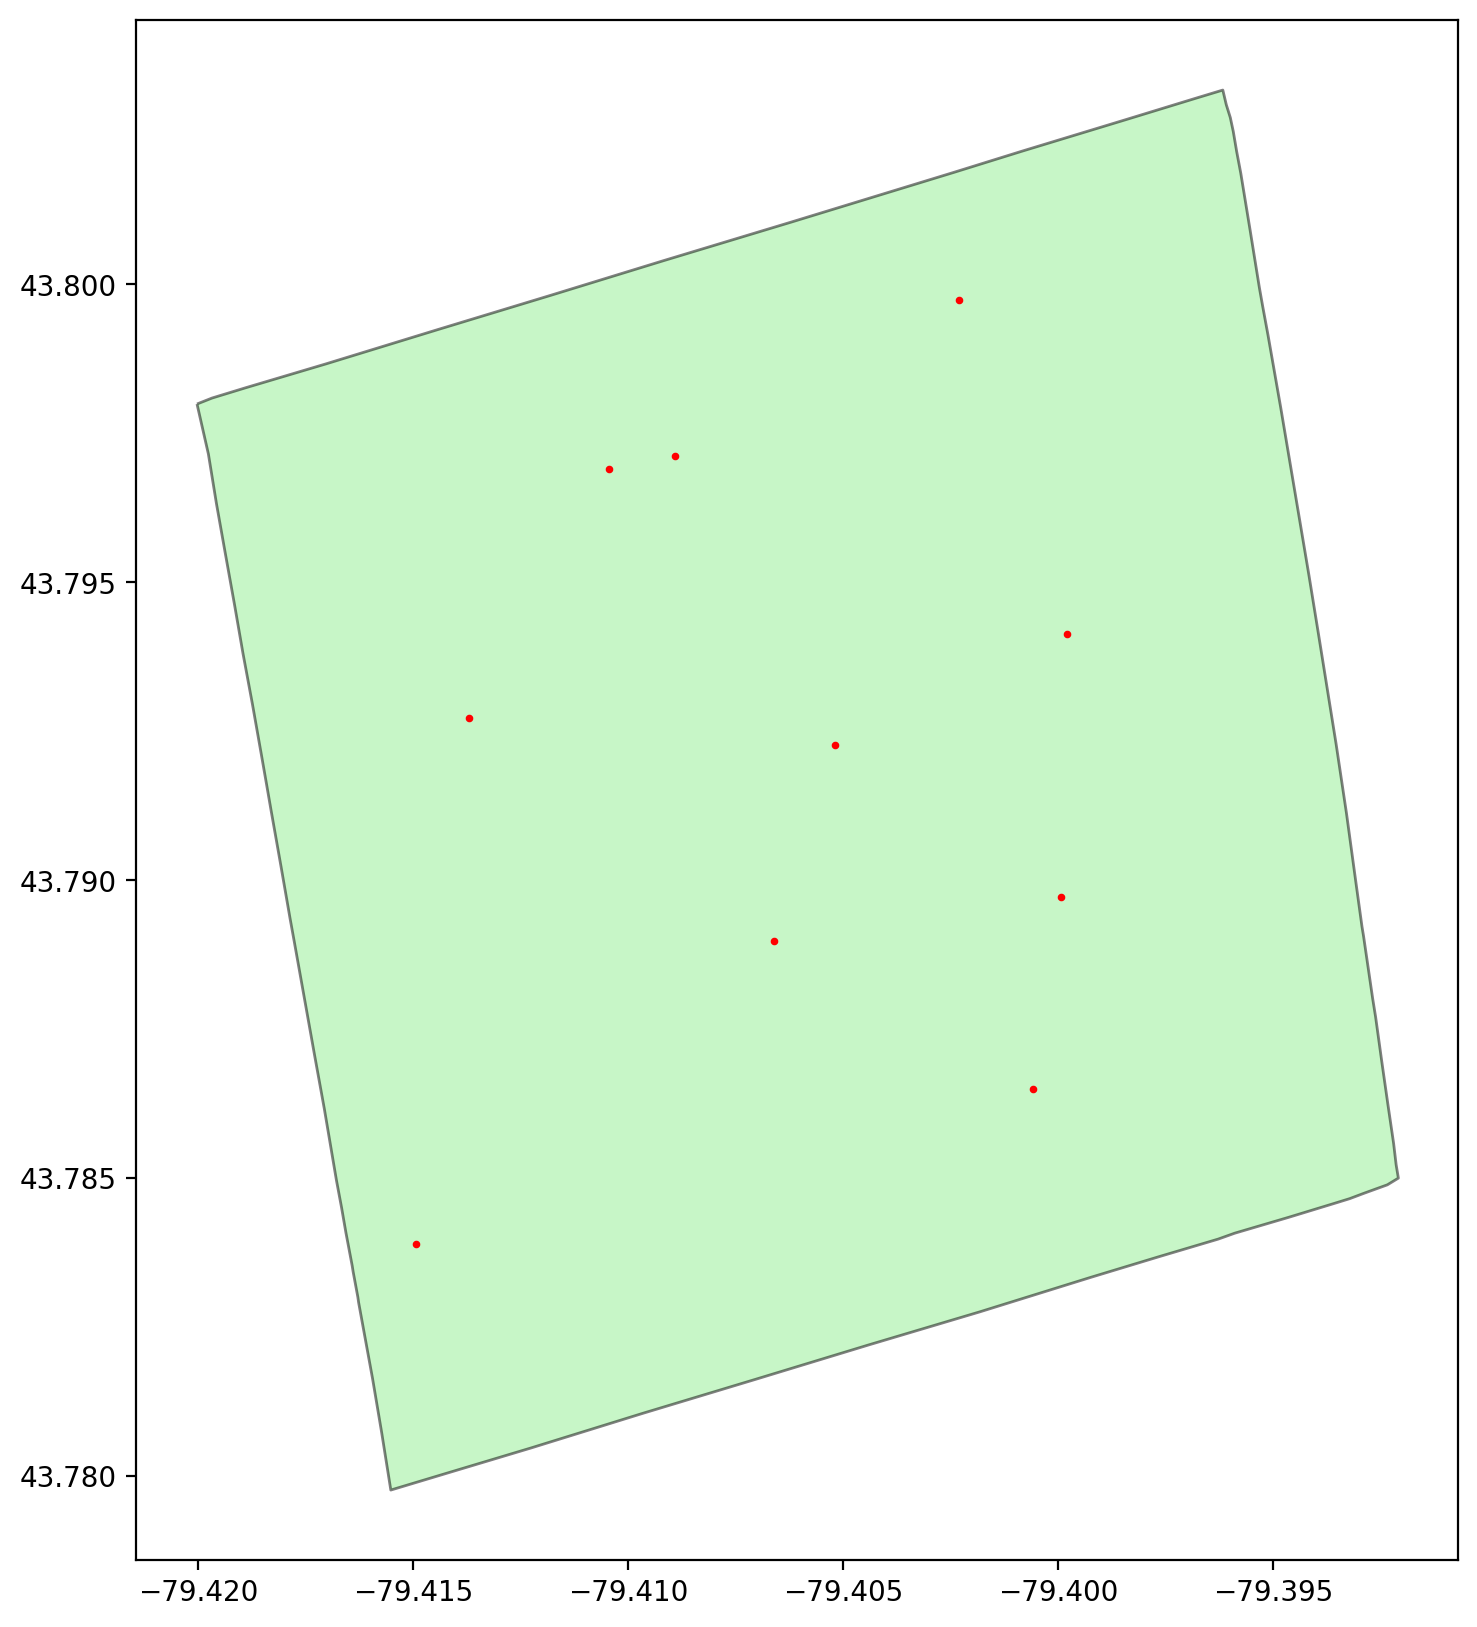

In [73]:
# select one hood_id to test
hood = 50
np.random.seed(123)
random_x, random_y = generate_random(10, hood)

# random points should lie within the neighbourhood
# no red dots should be outside the neighbourhood
ax = neighbourhoods.loc[neighbourhoods['Hood_ID'] == str(hood)].plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
plt.scatter(random_x, random_y, 
            color = 'red', s = 3)

In [74]:
np.random.seed(123)
missing_count[['Long', 'Lat']] = missing_count.apply(lambda x: generate_random(x['count'],x['Hood_ID']), axis=1)

70 points generated but only include the 53 points within the neighbourhood
66 points generated but only include the 36 points within the neighbourhood
42 points generated but only include the 25 points within the neighbourhood
32 points generated but only include the 17 points within the neighbourhood
22 points generated but only include the 15 points within the neighbourhood
20 points generated but only include the 13 points within the neighbourhood
18 points generated but only include the 12 points within the neighbourhood
9 points generated but only include the 7 points within the neighbourhood
7 points generated but only include the 5 points within the neighbourhood
9 points generated but only include the 5 points within the neighbourhood
8 points generated but only include the 5 points within the neighbourhood
10 points generated but only include the 4 points within the neighbourhood
5 points generated but only include the 4 points within the neighbourhood
11 points generated but

In [75]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count['len'] = missing_count['Long'].apply(lambda x: len(x))
missing_count

,Hood_ID,count,Long,Lat,len
0,119,53,"[-79.2905474645034, -79.31024017310659, -79.28...","[43.73845162529402, 43.75118356521948, 43.7450...",53
1,31,36,"[-79.4569641179742, -79.4484146065419, -79.466...","[43.722588866919466, 43.725195538263414, 43.72...",36
2,136,25,"[-79.17247756664437, -79.16873300409009, -79.1...","[43.75829731147847, 43.76188314701657, 43.7751...",25
3,76,17,"[-79.3837512293077, -79.38440980902507, -79.38...","[43.65404401527857, 43.64964469343091, 43.6502...",17
4,127,15,"[-79.25578936439268, -79.25033992847158, -79.2...","[43.753431143841475, 43.757729600347425, 43.74...",15
5,25,13,"[-79.50682850237801, -79.50238038884544, -79.5...","[43.73917913939486, 43.73652513135265, 43.7494...",13
6,27,12,"[-79.46898828337608, -79.49657018986852, -79.4...","[43.764745142230154, 43.756201350747354, 43.76...",12
7,124,7,"[-79.26753967137248, -79.25902272676625, -79.2...","[43.72598693702273, 43.73031281632378, 43.7321...",7
8,43,5,"[-79.31902003087431, -79.31054230854002, -79.3...","[43.72182427367543, 43.71611197128686, 43.7293...",5
9,118,5,"[-79.29023948997514, -79.29617293167792, -79.2...","[43.794858169895676, 43.790676936953375, 43.78...",5


In [76]:
# impute the missing long and lat values
for i in missing_count["Hood_ID"].unique():    
    index = (mci_df['Hood_ID'] == str(i)) & ((mci_df['Long'] == 0) | (mci_df['Lat'] == 0))
    # mci_df.loc[index, ['Long', 'Lat']] = 
    mci_df.loc[index, ['Long', 'Lat']] = pd.DataFrame([np.where(mci_df.loc[index, 'Long'] == 0, 
                                                                  missing_count[missing_count['Hood_ID'] == str(i)]['Long'].values[0],
                                                                  mci_df.loc[index, 'Long']),
                                                         np.where(mci_df.loc[index, 'Lat'] == 0, 
                                                                  missing_count[missing_count['Hood_ID'] == str(i)]['Lat'].values[0],
                                                                  mci_df.loc[index, 'Lat'])]).T.values

In [77]:
# check missing long and lat values are now imputed
mci_df.loc[missing_location]

,X,Y,Index_,event_unique_id,Division,occurrencedate,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId
4693,0.0,0.0,4795,GO-20141665589,D13,2014-03-08 05:00:00+00:00,2014,March,8,67,Saturday,Assault,3,Thistletown-Beaumond Heights,-79.568406,43.738024,4796
4694,0.0,0.0,4796,GO-20141665589,D13,2014-03-08 05:00:00+00:00,2014,March,8,67,Saturday,Assault,3,Thistletown-Beaumond Heights,-79.582009,43.743428,4797
20922,0.0,0.0,21719,GO-20143049745,D53,2014-10-05 04:00:00+00:00,2014,October,5,278,Sunday,Assault,102,Forest Hill North,-79.421889,43.707009,21220
27561,0.0,0.0,27419,GO-20143474848,D32,2014-12-12 05:00:00+00:00,2014,December,12,346,Friday,Robbery,51,Willowdale East,-79.409250,43.762692,27919
41791,0.0,0.0,42104,GO-20151057899,D22,2015-06-01 04:00:00+00:00,2015,June,1,152,Monday,Assault,17,Mimico (includes Humber Bay Shores),-79.501777,43.615239,42222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255637,0.0,0.0,258264,GO-20201742672,D41,2020-09-14 04:00:00+00:00,2020,September,14,258,Monday,Auto Theft,119,Wexford/Maryvale,-79.300856,43.751013,258703
257453,0.0,0.0,260065,GO-20213400,D33,2021-01-01 05:00:00+00:00,2021,January,1,1,Friday,Auto Theft,43,Victoria Village,-79.305742,43.728405,260522
257455,0.0,0.0,260066,GO-20213400,D33,2021-01-01 05:00:00+00:00,2021,January,1,1,Friday,Auto Theft,43,Victoria Village,-79.317201,43.723712,260524
257596,0.0,0.0,260919,GO-2021413504,D22,2021-03-05 05:00:00+00:00,2021,March,5,64,Friday,Auto Theft,17,Mimico (includes Humber Bay Shores),-79.501599,43.621388,260665


### Add geometry for points

In [78]:
mci_df['geometry'] = mci_df.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)

C:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [79]:
# Documentation: The location of crime occurrences have been deliberately offset 
# to the nearest road intersection node 
# to protect the privacy of parties involved in the occurrence
mci_point = gpd.GeoDataFrame(mci_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

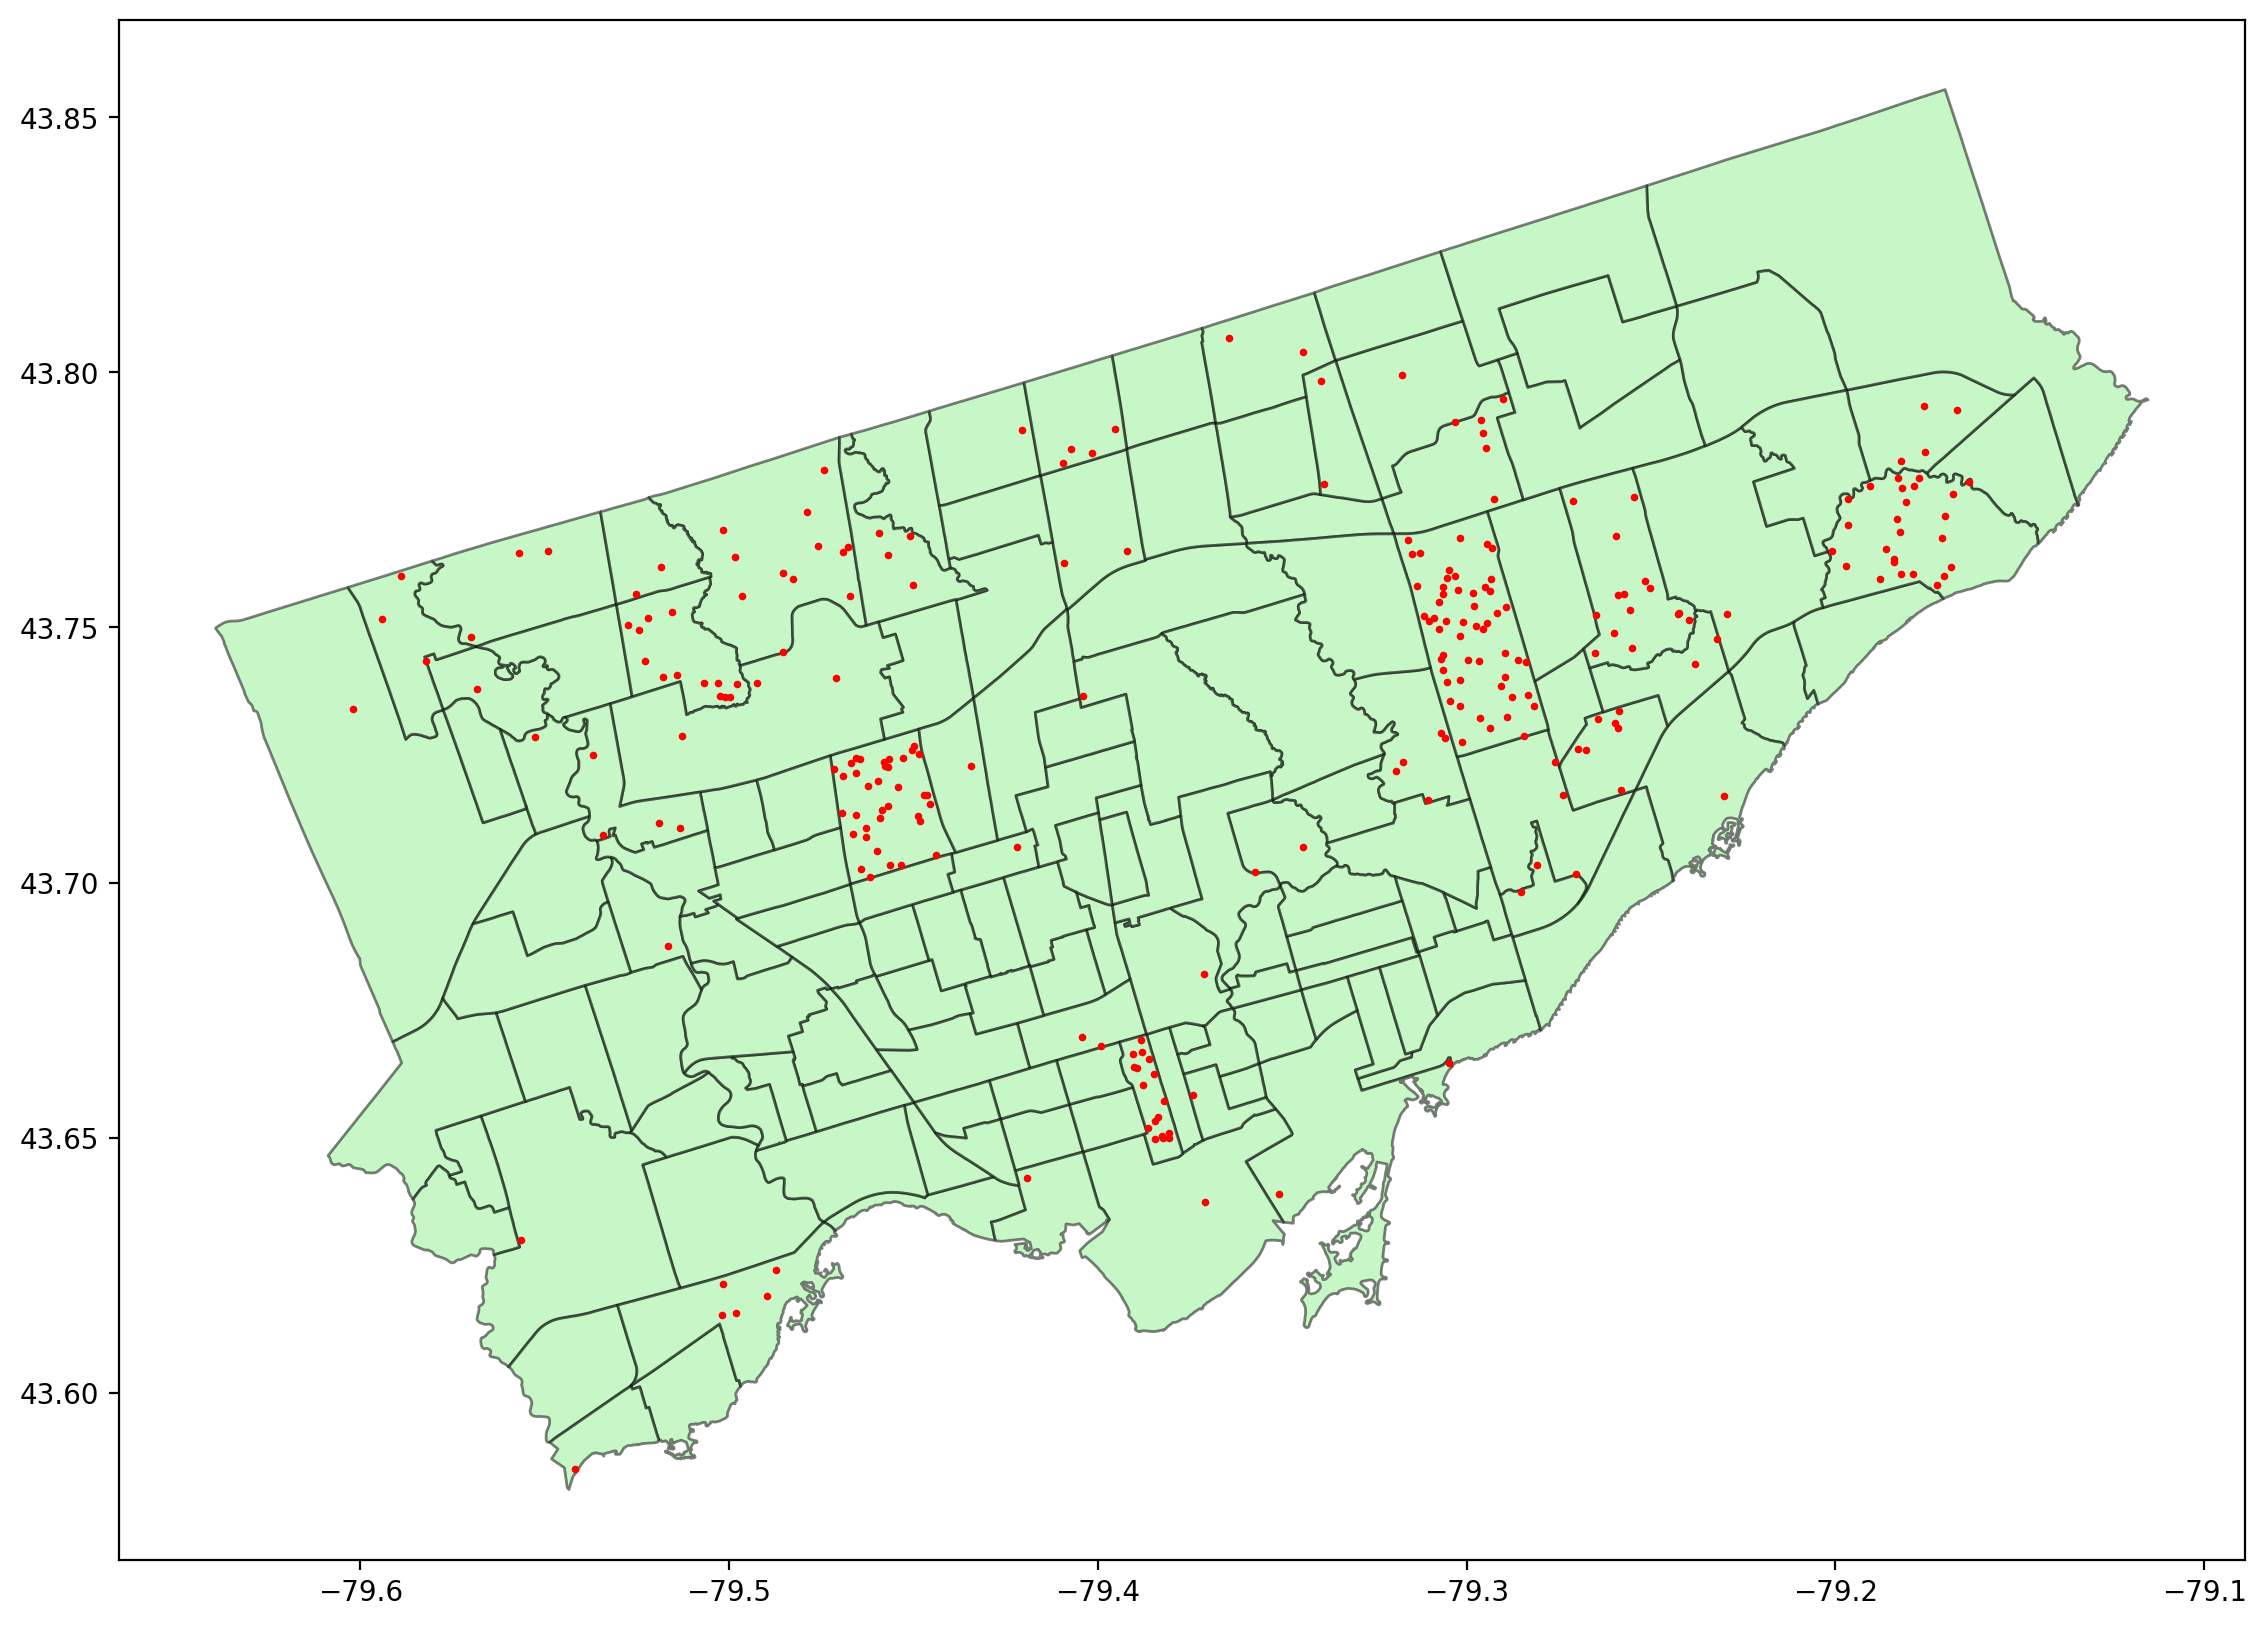

In [80]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

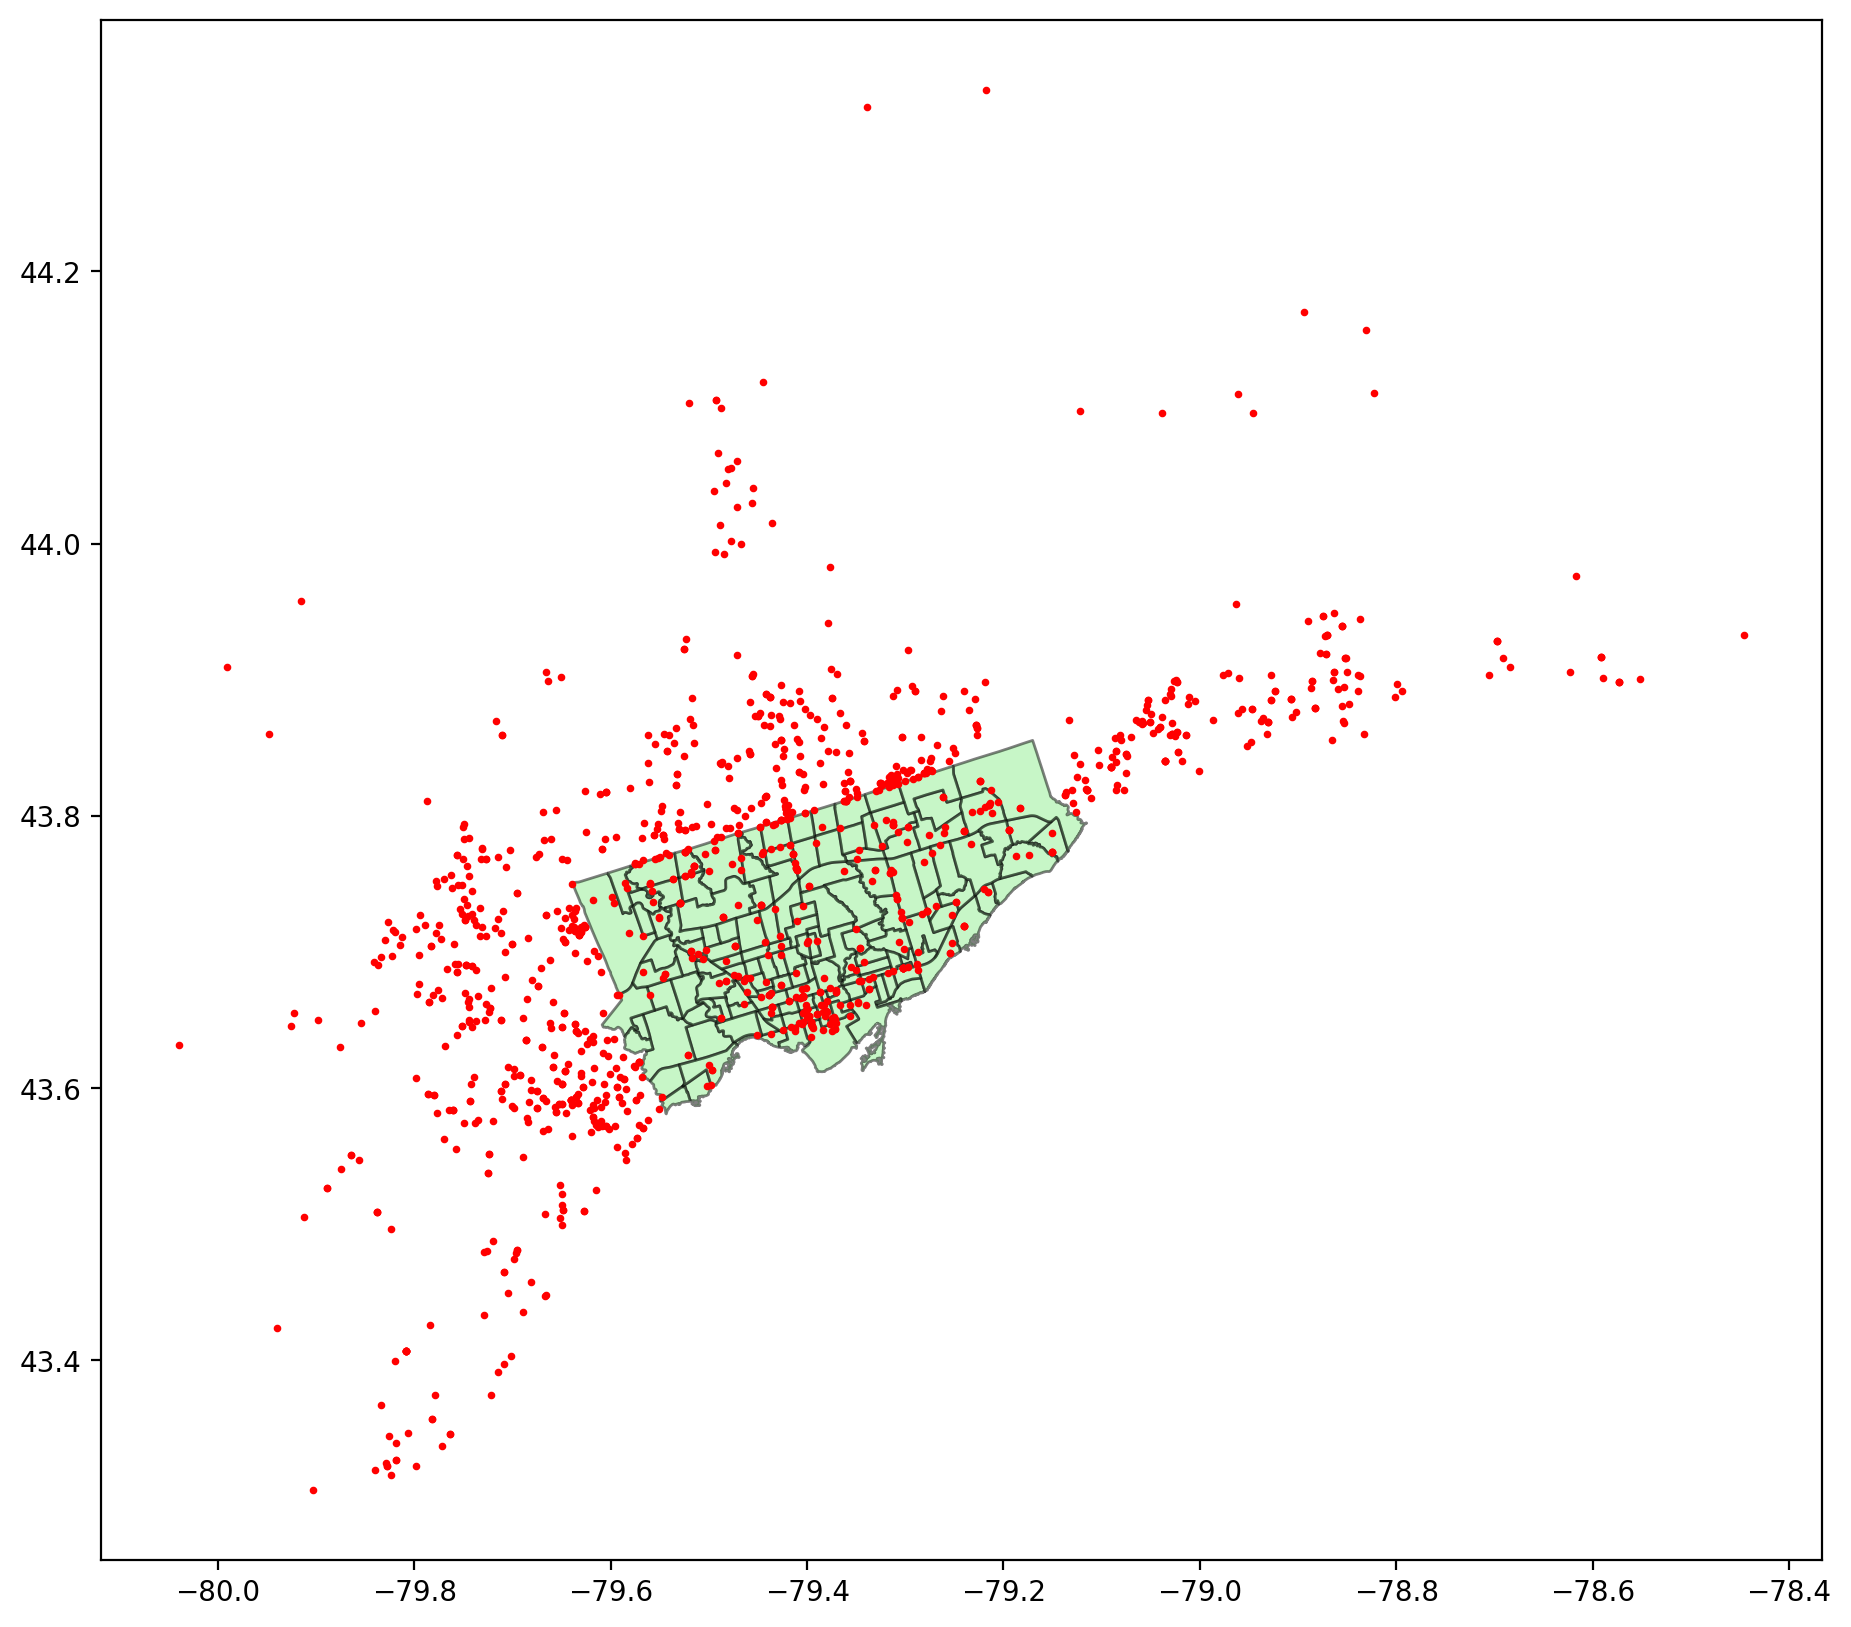

In [81]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [82]:
# get the points contained within the neighbourhoods
NSA_within_neighbourhood = gpd.sjoin(mci_point[mci_point['Neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
mci_point.loc[NSA_within_neighbourhood.index, ['Hood_ID', 'Neighbourhood']] = NSA_within_neighbourhood[['Hood_ID_right', 'Neighbourhood_right']].values

C:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

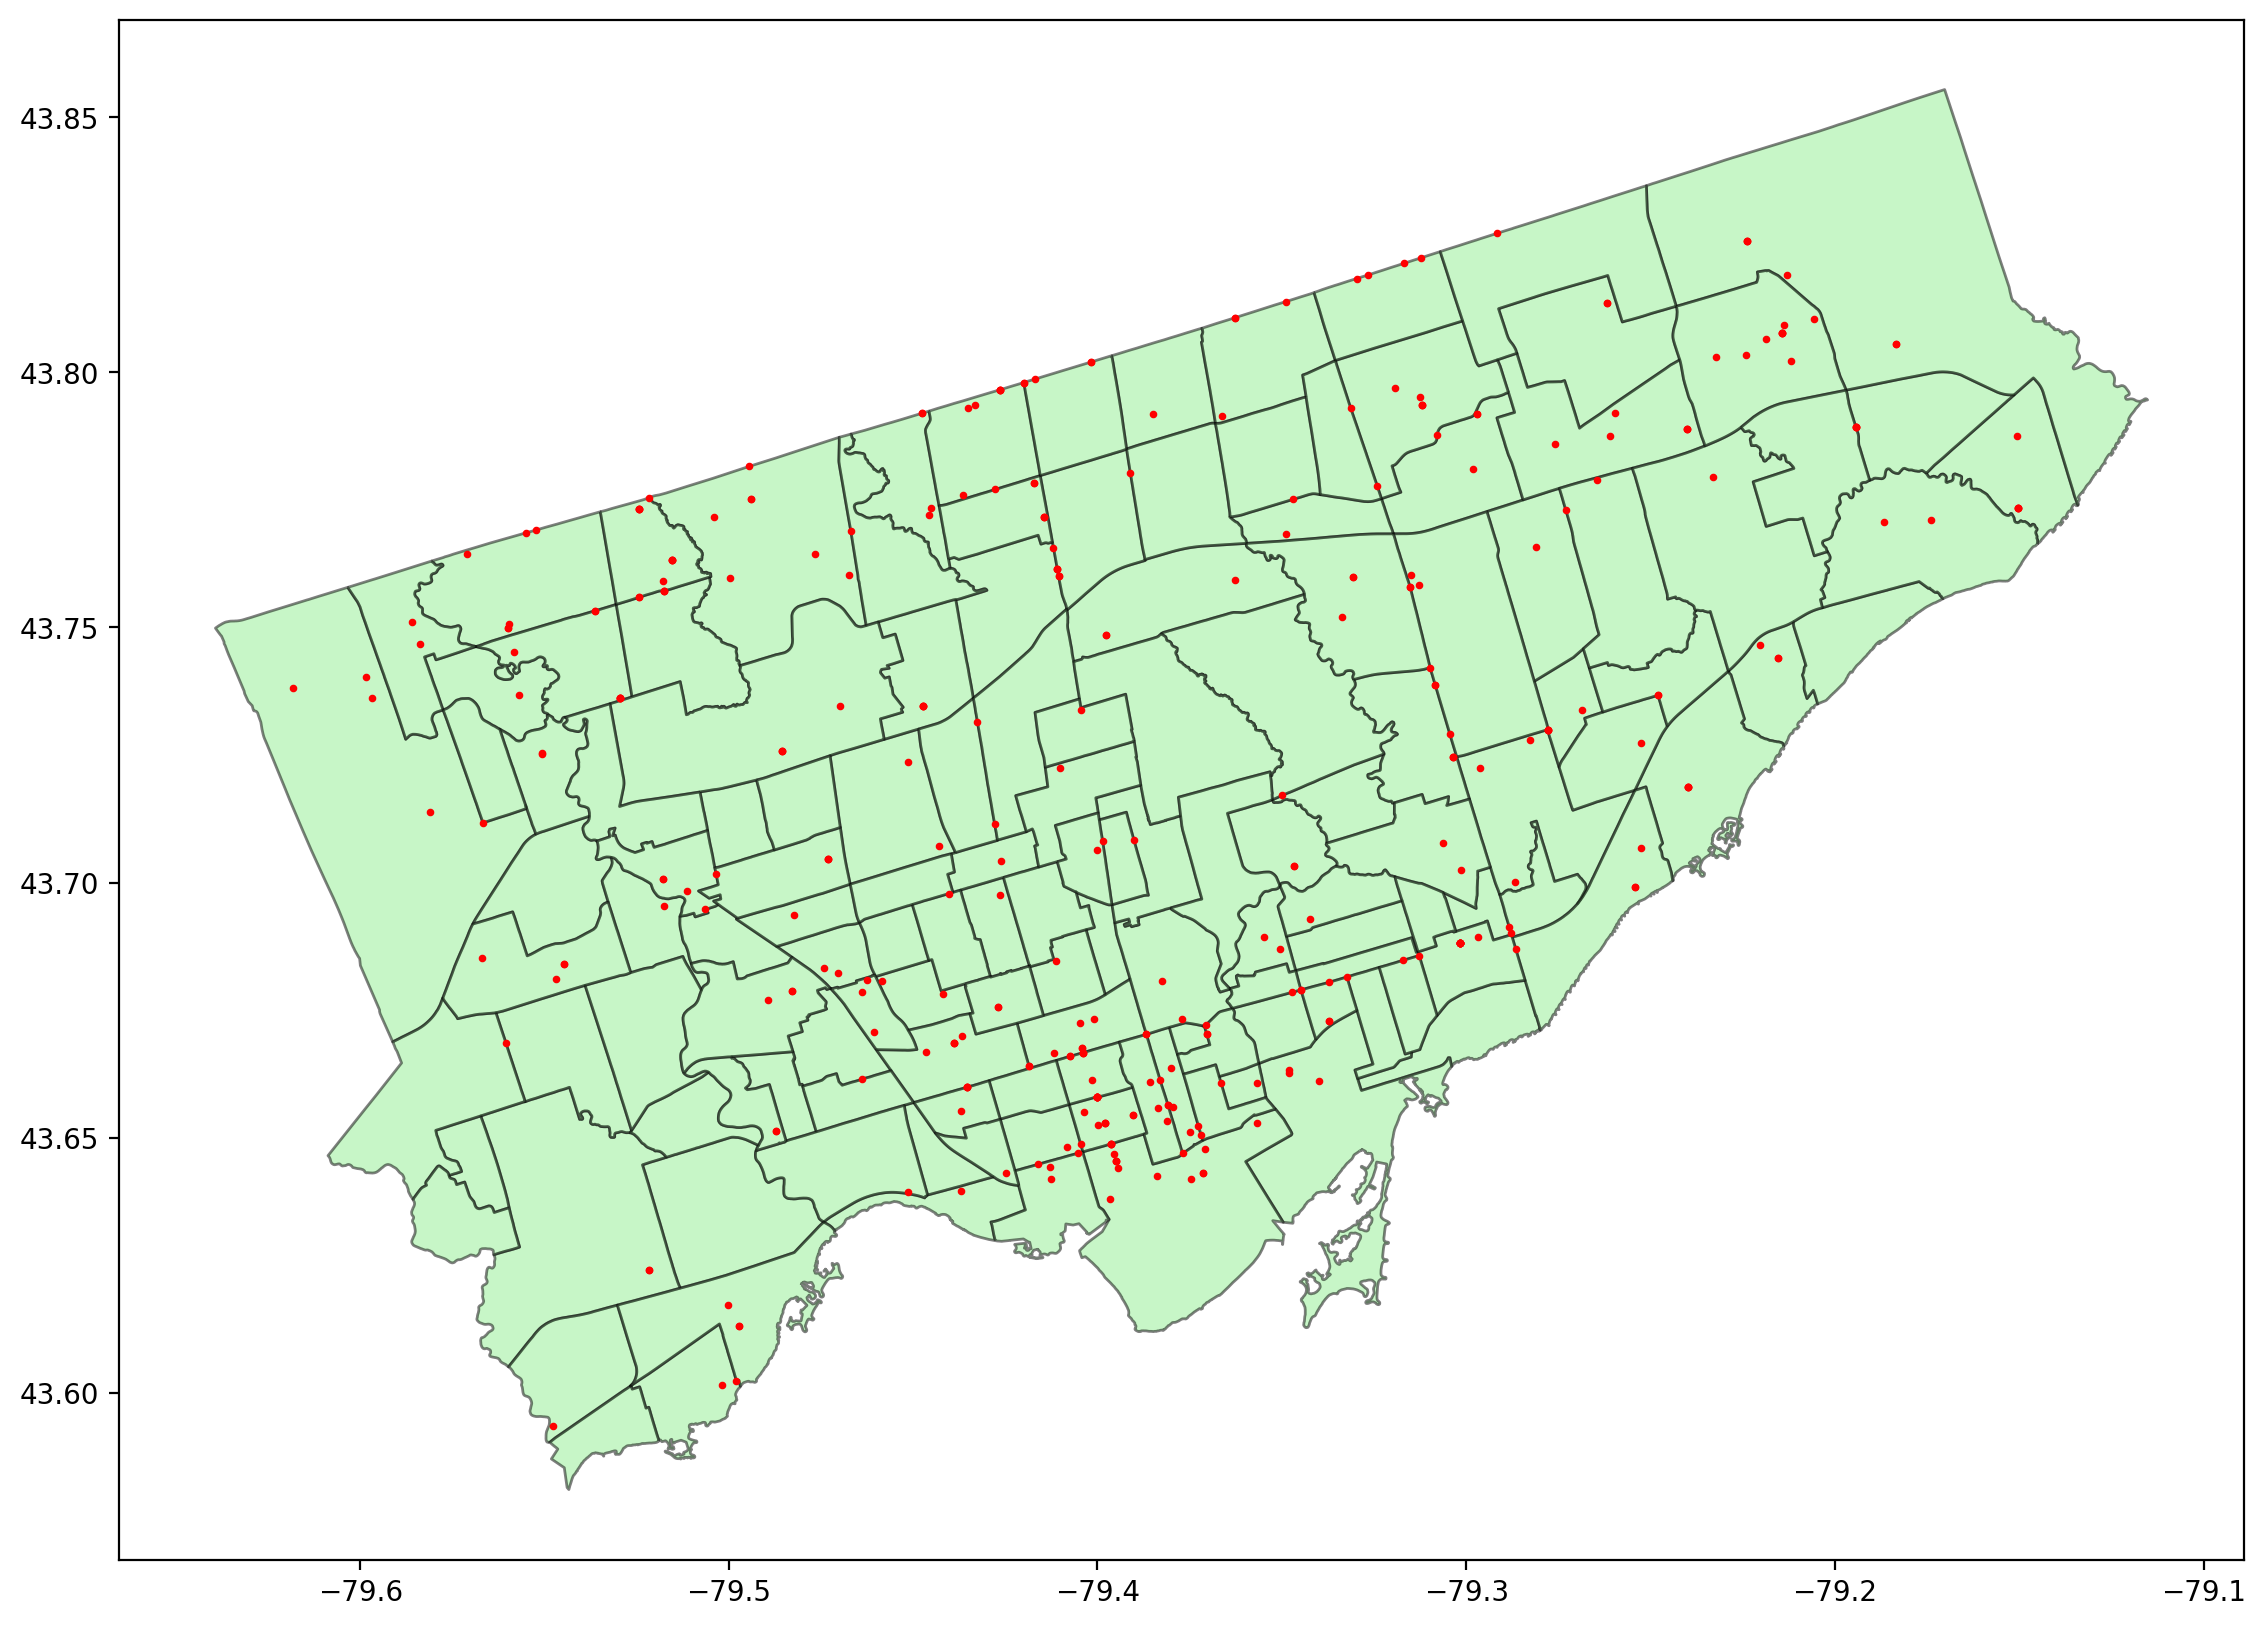

In [83]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

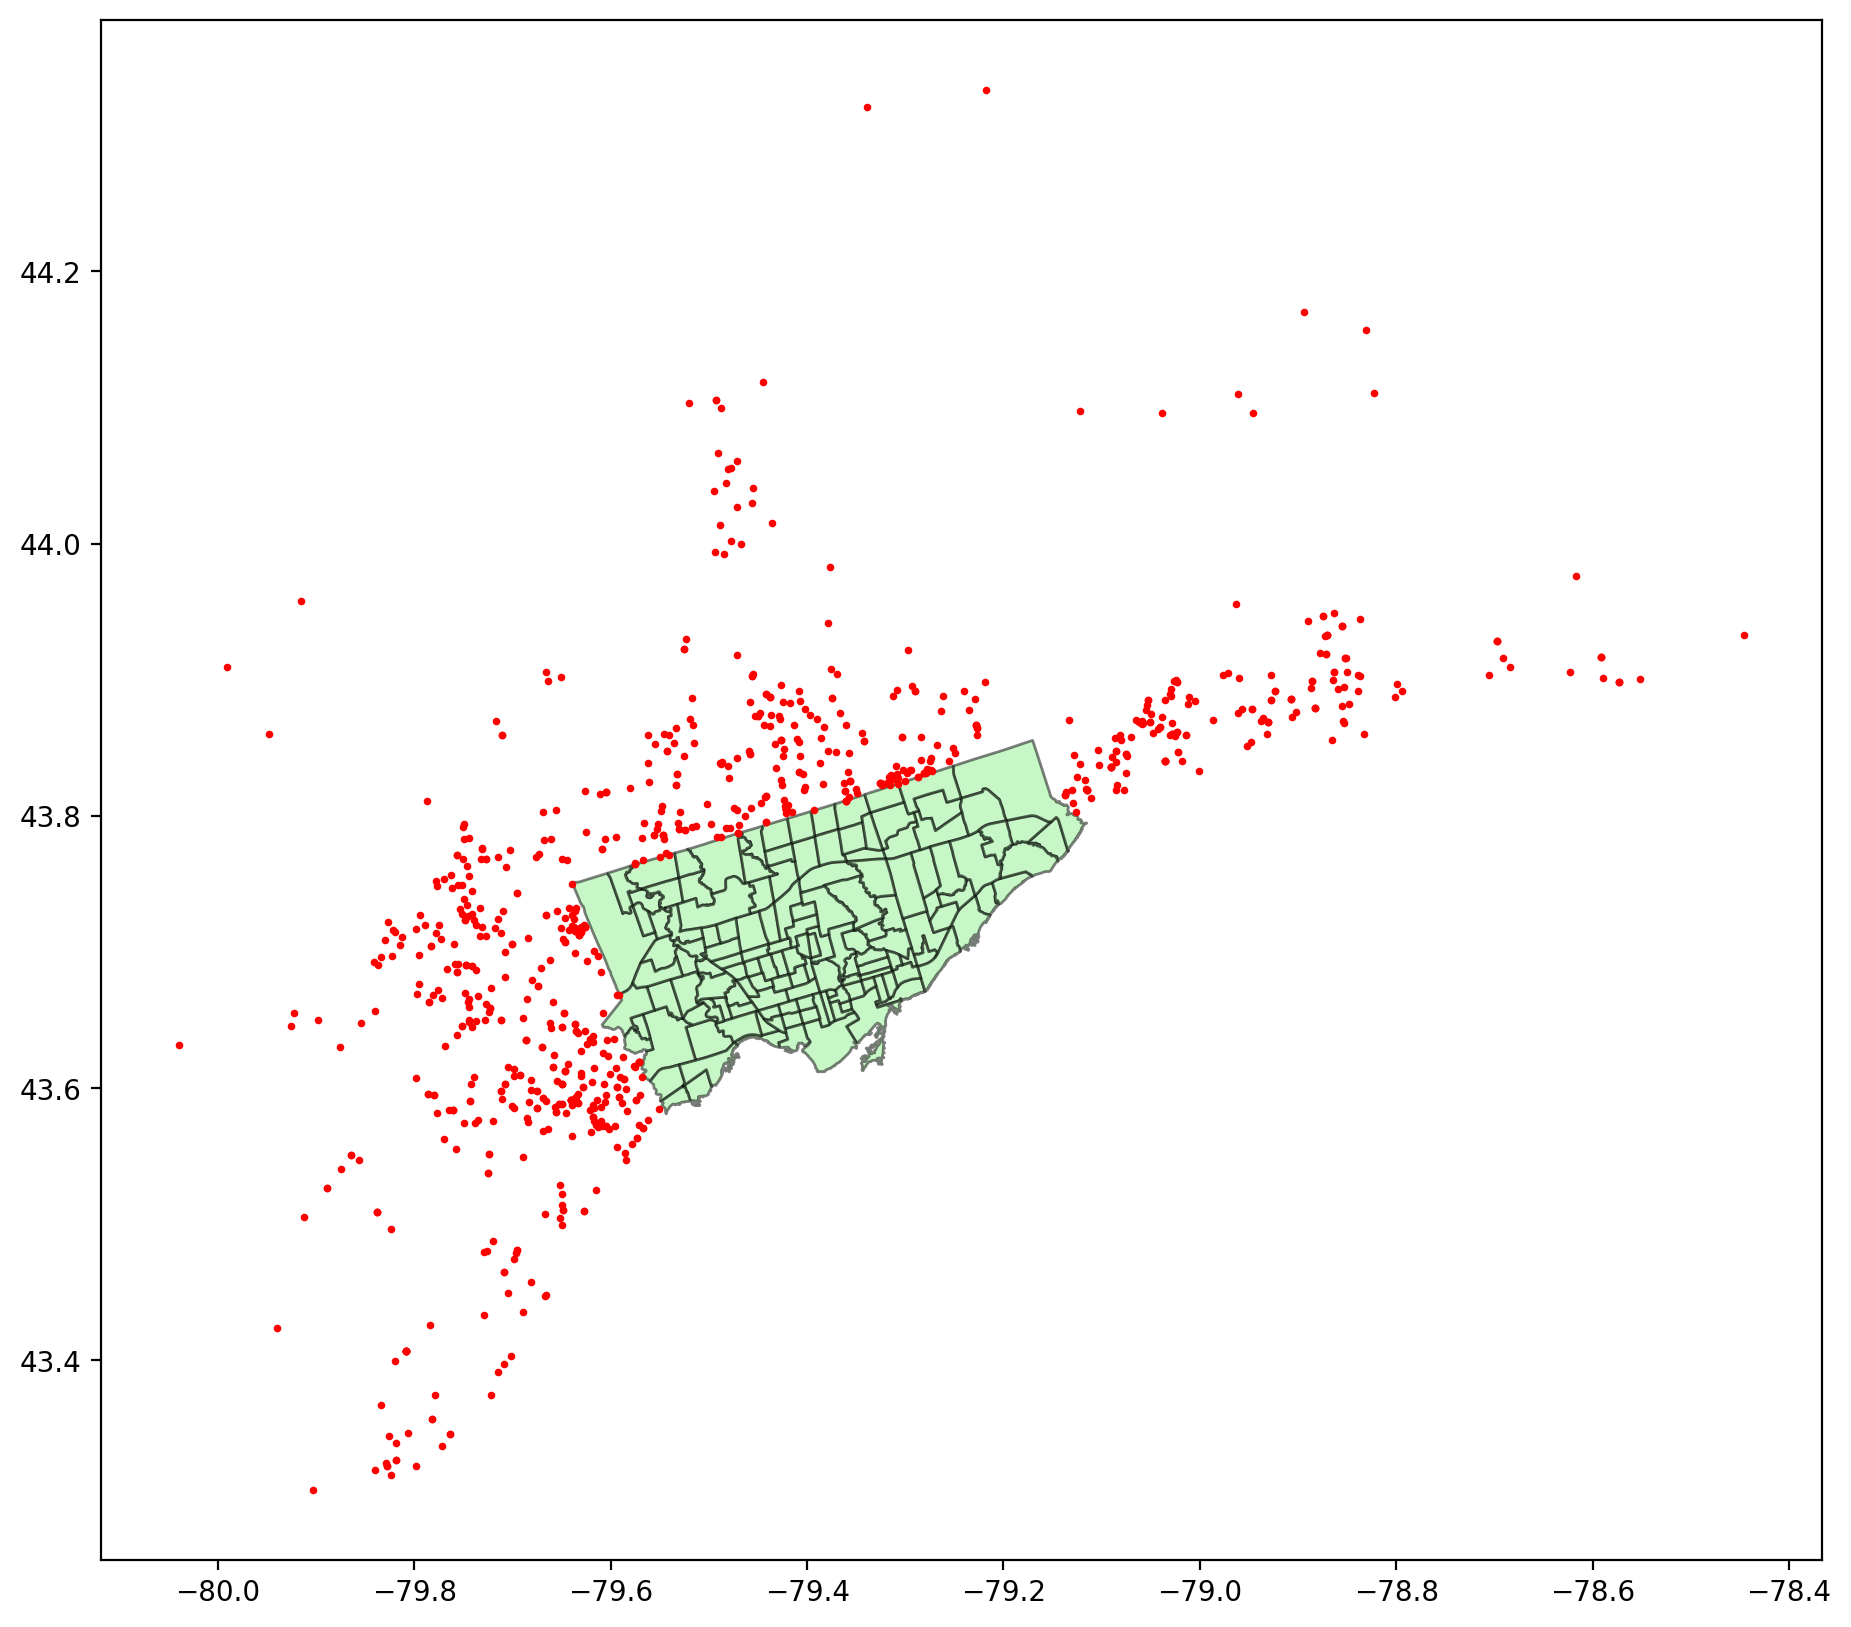

In [84]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
# no red dots should be inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

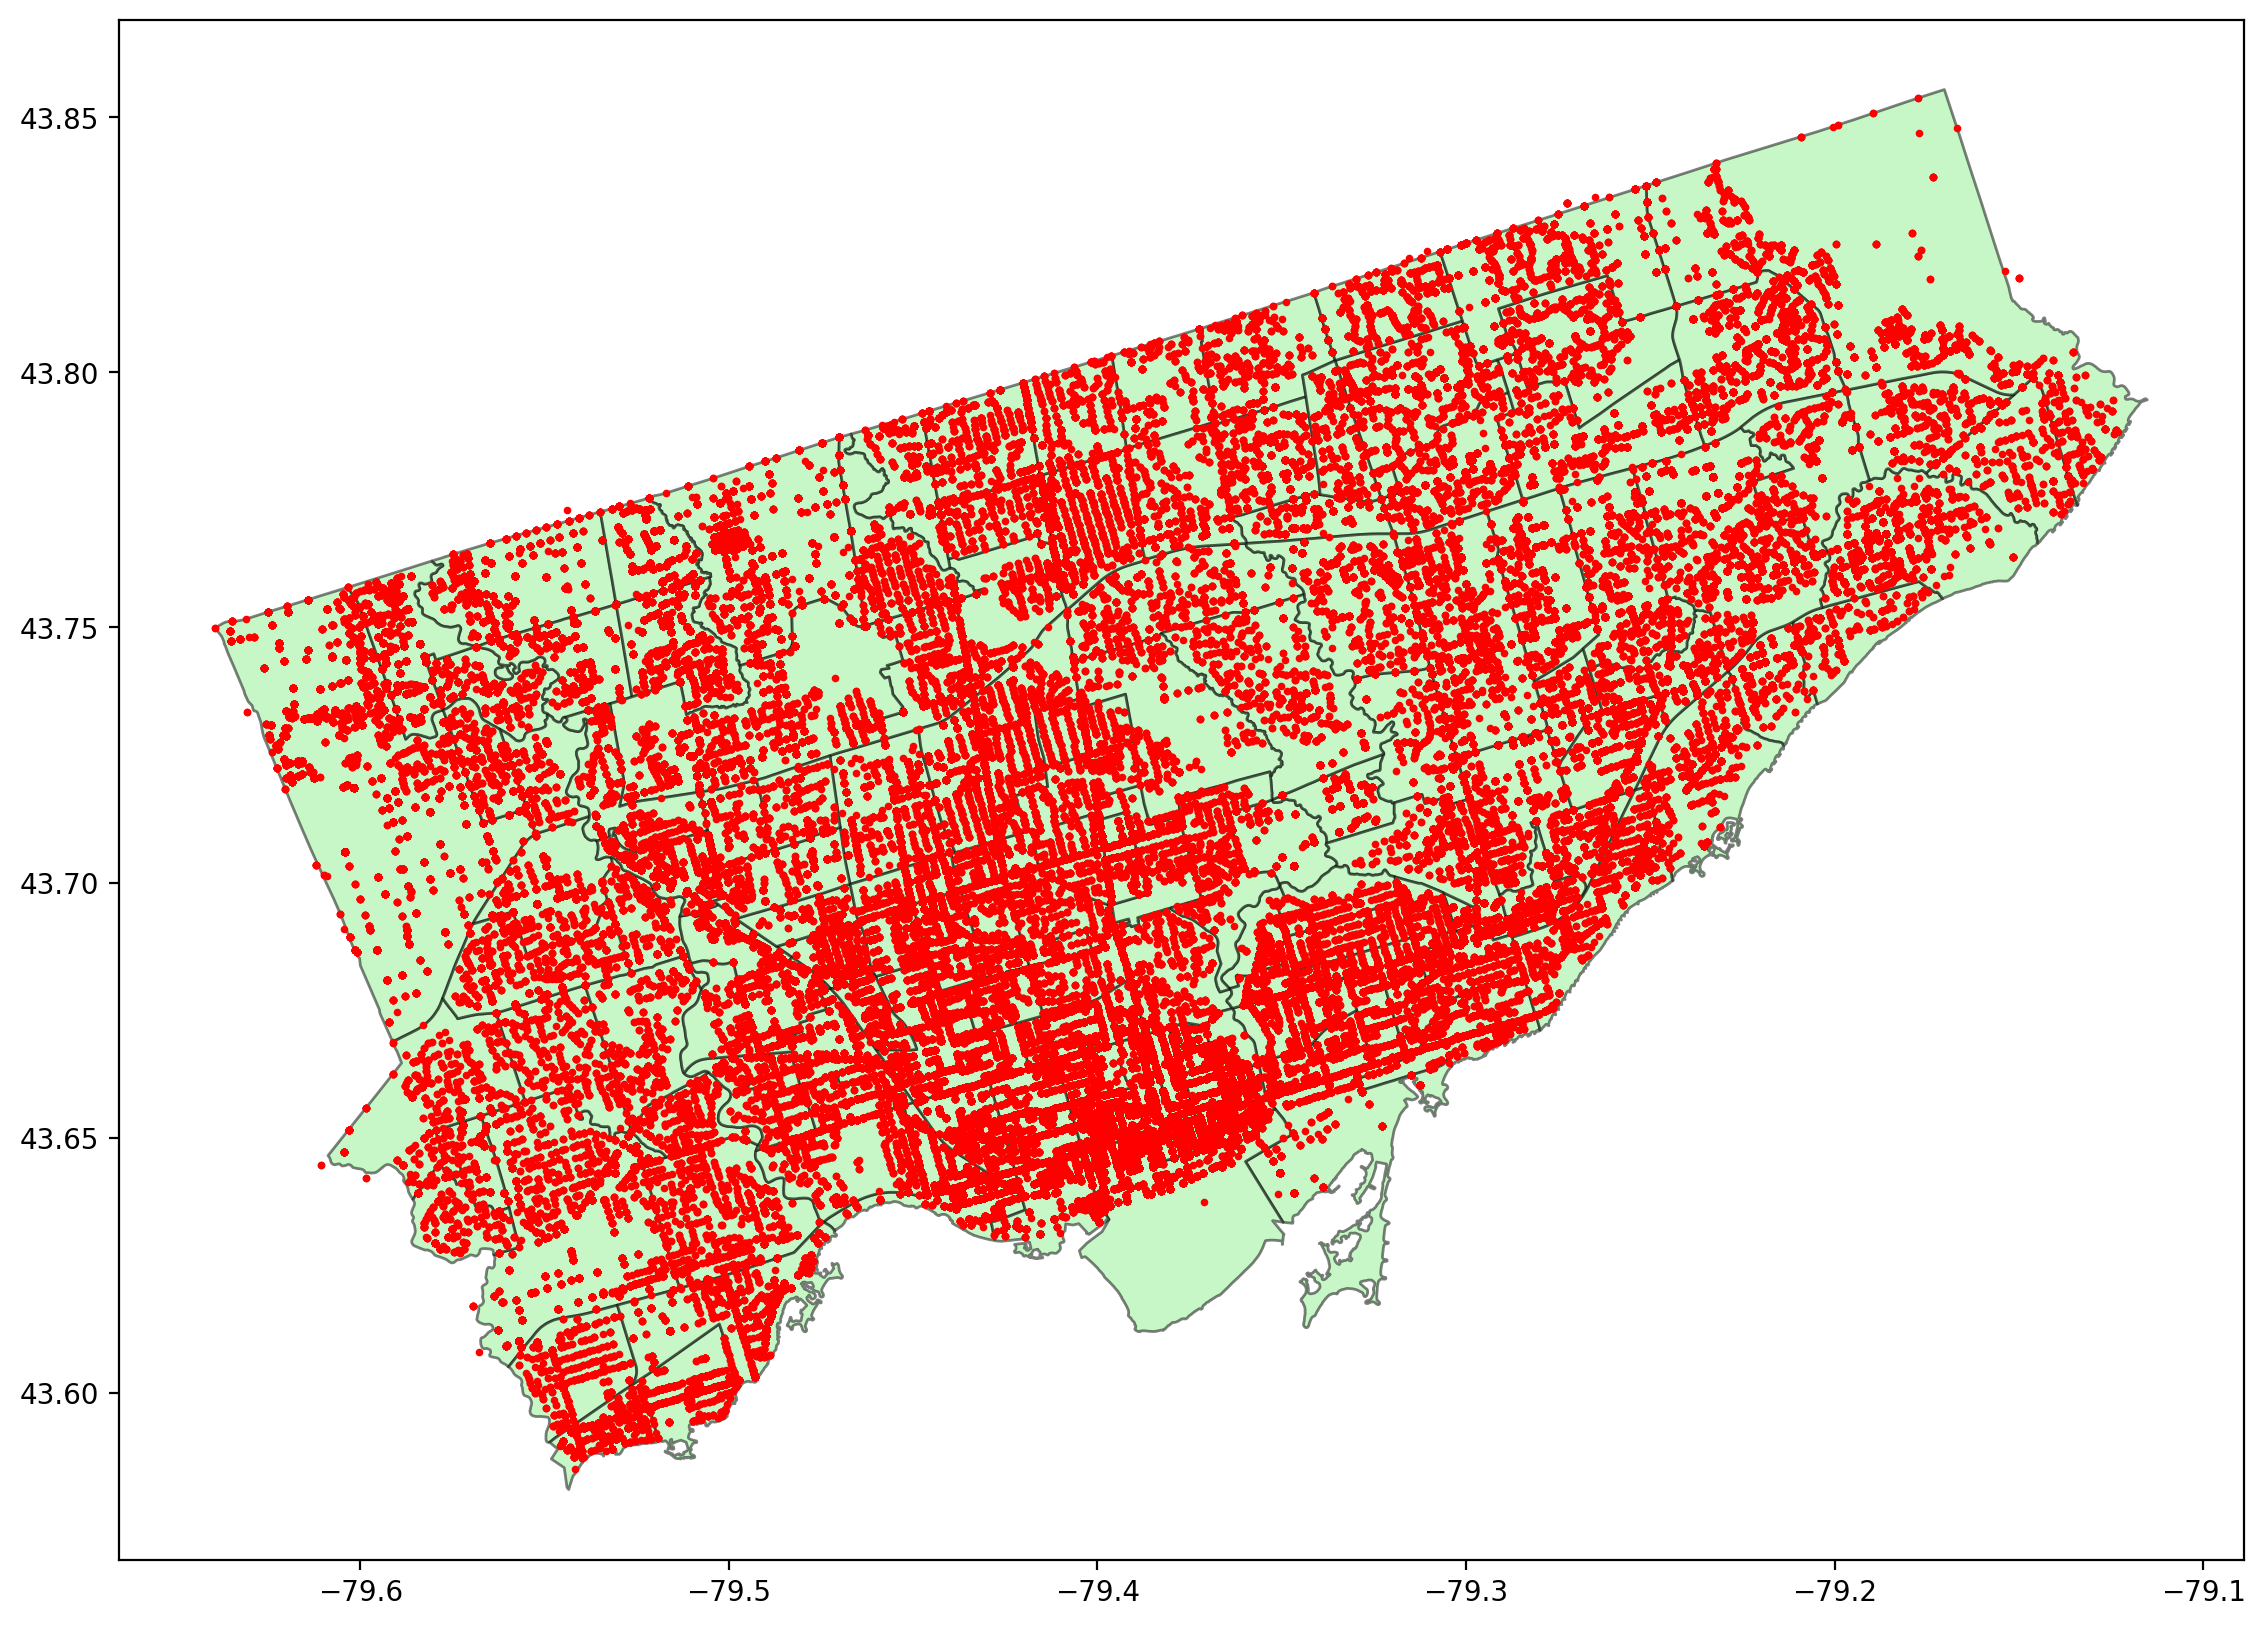

In [85]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
mci_point[mci_point['Neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [86]:
mci_point

,X,Y,Index_,event_unique_id,Division,occurrencedate,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
0,-8.854229e+06,5.425760e+06,1,GO-20141624853,D31,2014-03-02 05:00:00+00:00,2014,March,2,61,Sunday,Assault,22,Humbermede,-79.538894,43.743025,1,POINT (-79.53889 43.74302)
1,-8.834951e+06,5.412259e+06,2,GO-20141625057,D51,2014-03-02 05:00:00+00:00,2014,March,2,61,Sunday,Break and Enter,73,Moss Park,-79.365716,43.655340,2,POINT (-79.36572 43.65534)
2,-8.825836e+06,5.417935e+06,3,GO-20141259602,D41,2013-12-31 05:00:00+00:00,2013,December,31,365,Tuesday,Break and Enter,121,Oakridge,-79.283837,43.692217,3,POINT (-79.28384 43.69222)
3,-8.847703e+06,5.416571e+06,4,GO-20141260128,D12,2014-01-01 05:00:00+00:00,2014,January,1,1,Wednesday,Assault,111,Rockcliffe-Smythe,-79.480268,43.683360,4,POINT (-79.48027 43.68336)
4,-8.837275e+06,5.411569e+06,5,GO-20141259483,D52,2013-12-31 05:00:00+00:00,2013,December,31,365,Tuesday,Assault,76,Bay Street Corridor,-79.386589,43.650853,5,POINT (-79.38659 43.65085)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266134,-8.859224e+06,5.426345e+06,1366,GO-2020898005,D23,2020-05-14 04:00:00+00:00,2020,May,14,135,Thursday,Homicide,2,Mount Olive-Silverstone-Jamestown,-79.583768,43.746816,1248,POINT (-79.58377 43.74682)
266135,-8.830322e+06,5.431112e+06,1367,GO-2020915335,D42,2020-05-17 04:00:00+00:00,2020,May,17,138,Sunday,Homicide,46,Pleasant View,-79.324129,43.777743,1249,POINT (-79.32413 43.77774)
266136,-8.822707e+06,5.425298e+06,1368,GO-2020909524,D41,2020-05-19 04:00:00+00:00,2020,May,19,140,Tuesday,Homicide,138,Eglinton East,-79.255724,43.740025,1250,POINT (-79.25572 43.74002)
266137,-8.837879e+06,5.410726e+06,1369,GO-2020971451,D52,2020-05-26 04:00:00+00:00,2020,May,26,147,Tuesday,Homicide,77,Waterfront Communities-The Island,-79.392021,43.645372,1251,POINT (-79.39202 43.64537)


In [87]:
mci_point.groupby(['Hood_ID', 'Neighbourhood']).size().reset_index(name='count')[mci_point.groupby(['Hood_ID', 'Neighbourhood']).size().reset_index(name='count').duplicated(subset='Hood_ID', keep=False)]

,Hood_ID,Neighbourhood,count


In [88]:
# output file to clean_data folder
# csv instead of geojson due to size
mci_point.to_csv('./clean_data/mci_point.csv', index=False)